## setup

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io
from scipy import stats
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# plt use ggplot stylesheet
plt.style.use('ggplot')

In [21]:
with open('temp/image-scoring-cogsci-data.json', 'r') as f:
    data = json.load(f)
    data = [entry for entry in data if entry.get('trial_type') == 'img-synth-response-anim']

print(f'Found {len(data)} sound trials')

Found 2344 sound trials


In [22]:
musical_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'musical']
referential_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'referential']
print(f'Found {len(musical_trials)} musical condition sounds')
print(f'Found {len(referential_trials)} referential condition sounds')

Found 1171 musical condition sounds
Found 1173 referential condition sounds


### a few spectrograms

In [23]:
def parse_audio_blob(audio_blob_array):
    audio_bytes = bytes(audio_blob_array)
    with io.BytesIO(audio_bytes) as bio:
        audio = AudioSegment.from_file(bio)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    samples = samples / (2**15)  # 16-bit audio
    sample_rate = audio.frame_rate
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
    return samples, sample_rate

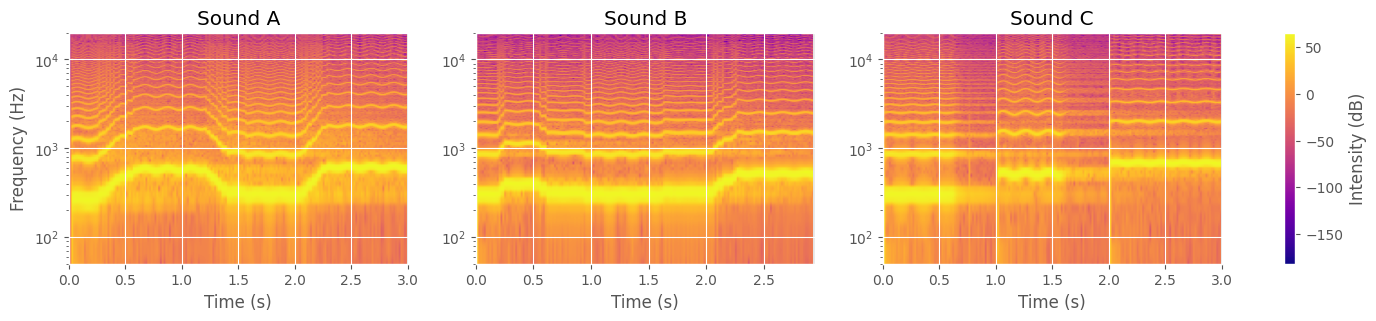

In [24]:
example_audios = [data[i]['audio_blob']['data'] for i in range(9,12)]
example_audios_samples = []
for i, audio_data in enumerate(example_audios):
    # convert webm (from MediaRecorder, saved as array) to audio samples
    example_audios_samples.append(parse_audio_blob(audio_data)[0])
    

# display examples audios as spectrograms in subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

for i, audio_segment in enumerate(example_audios_samples):
    # Convert stereo to mono by averaging channels, or take just one channel
    if audio_segment.ndim > 1:
        audio_mono = audio_segment.mean(axis=1) if audio_segment.shape[1] == 2 else audio_segment[:, 0]
    else:
        audio_mono = audio_segment
    
    axes[i].specgram(audio_mono, Fs=48000, NFFT=1024, noverlap=256, cmap='plasma')
    axes[i].set_xlim(0, len(audio_mono+0.001)/48000)
    axes[i].set_yscale('log')
    axes[i].set_ylim(50, 20000)
    axes[i].set_title(f'Sound {chr(65+i)}')  # Sound A, Sound B, C, etc
    axes[i].set_xlabel('Time (s)')
    if(i == 0):
        axes[i].set_ylabel('Frequency (Hz)')
    if(i == len(example_audios_samples)-1):
        cbar = plt.colorbar(axes[i].images[0], ax=axes, orientation='vertical', fraction=0.02)
        cbar.set_label('Intensity (dB)')

# plt.tight_layout()
plt.show()

## interface-space analysis

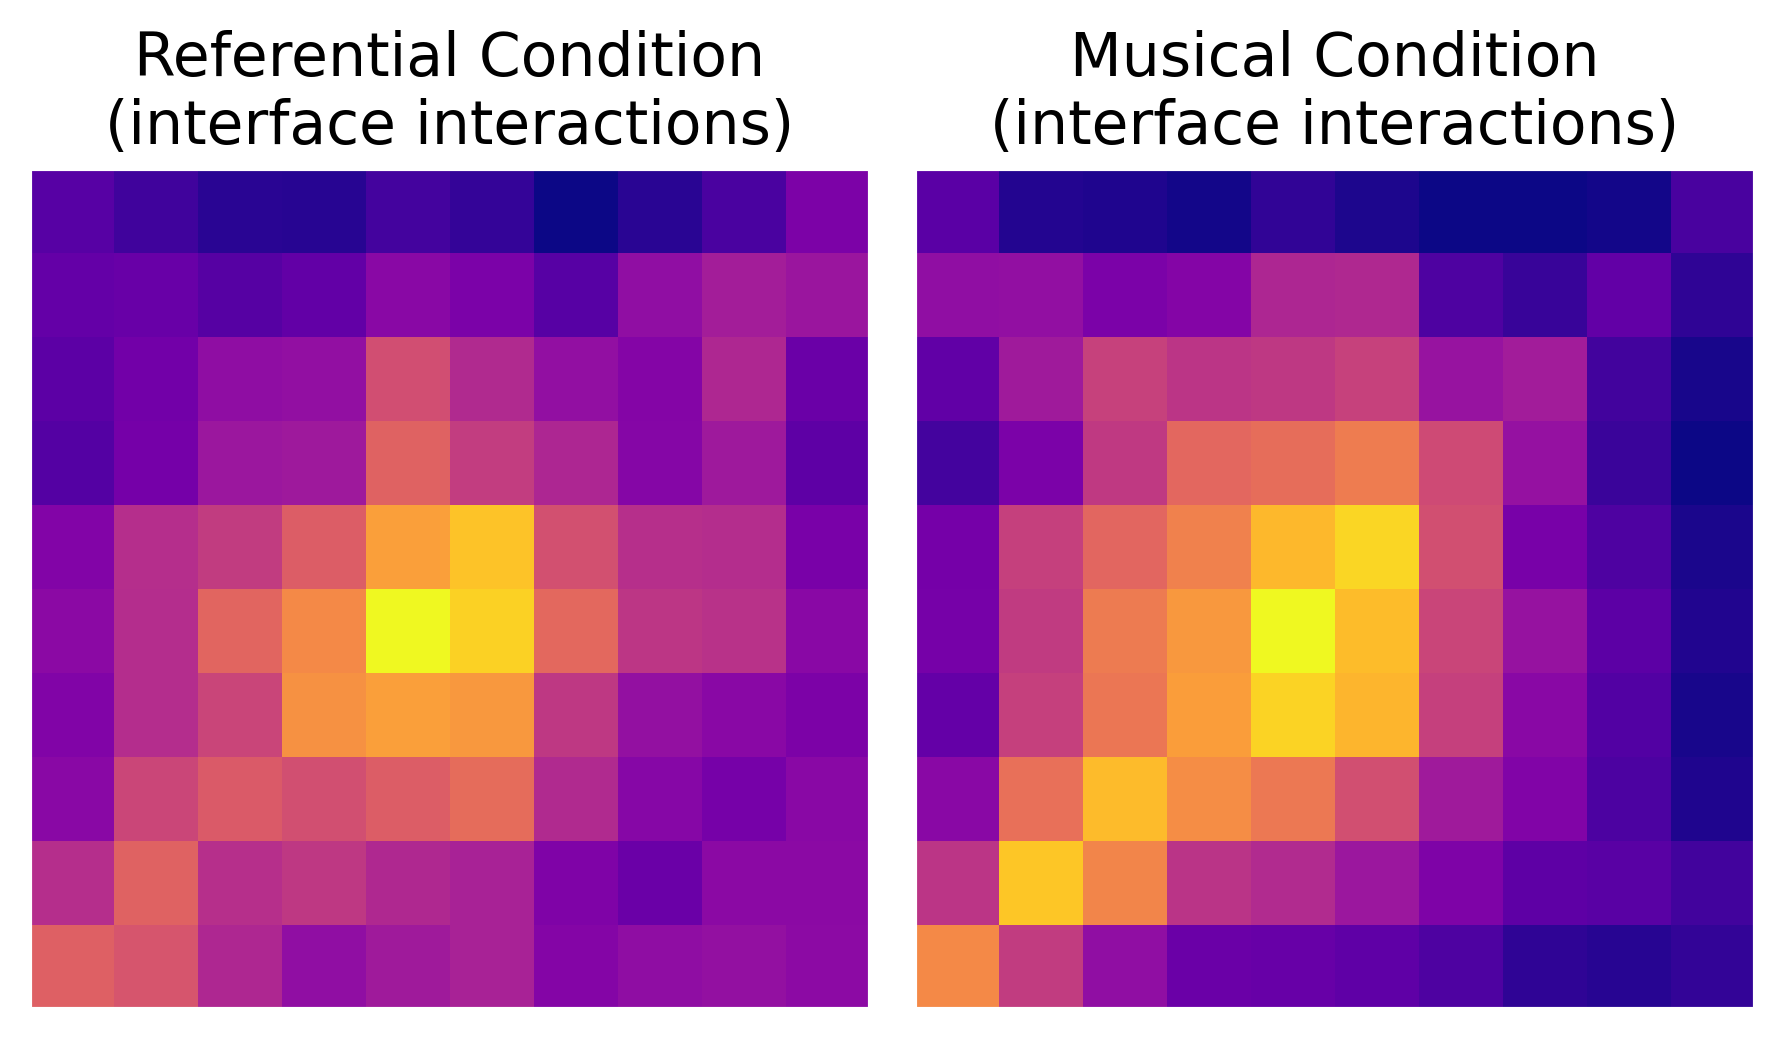

In [25]:
heatmap_resolution = 10
canvas_size = 400  # pixels, set in jspsych experiment code

musical_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
referential_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
musical_xvals = []
musical_yvals = []
referential_xvals = []
referential_yvals = []

for entry in musical_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    musical_heatmap[y_bin, x_bin] += 1
                    musical_xvals.append(x)
                    musical_yvals.append(y)

for entry in referential_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    referential_heatmap[y_bin, x_bin] += 1
                    referential_xvals.append(x)
                    referential_yvals.append(y)
# normalize heatmaps
musical_heatmap /= np.sum(musical_heatmap)
referential_heatmap /= np.sum(referential_heatmap)

plt.figure(figsize=(9, 4), dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(referential_heatmap, cmap='plasma', interpolation='nearest')
plt.title('Referential Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(musical_heatmap, cmap='plasma', interpolation='nearest')
plt.title('Musical Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

### heatmap entropy

In [99]:
# entropy of (normalized) heatmaps
def compute_entropy(heatmap):
    heatmap_flat = heatmap.flatten()
    heatmap_flat = heatmap_flat[heatmap_flat > 0]  # remove zero entries
    entropy = -np.sum(heatmap_flat * np.log2(heatmap_flat))
    return entropy

entropy_musical = compute_entropy(musical_heatmap)
entropy_referential = compute_entropy(referential_heatmap)
print(f'entropy, pleasing: {entropy_musical:.3f} bits')
print(f'entropy, referential: {entropy_referential:.3f} bits')
print(f'difference (pleasing - referential): {entropy_musical - entropy_referential:.3f} bits')
print(f'compare to perfectly uniform distribution: {np.log2(heatmap_resolution**2):.3f} bits')

entropy, pleasing: 6.446 bits
entropy, referential: 6.540 bits
difference (pleasing - referential): -0.094 bits
compare to perfectly uniform distribution: 6.644 bits


Number of participants: 268
Participants with musical data: 130
Participants with referential data: 132

Running 1000 participant-level permutations...


100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

  Permutation 1000/1000

PERMUTATION TEST RESULTS (Participant-Level)
Observed entropy difference: -0.0940 bits
Null distribution mean: 0.0006 bits
Null distribution std: 0.0292 bits
Two-tailed p-value: 0.0000
Significant at α=0.05: Yes
Significant at α=0.01: Yes
Standardized effect size: -3.216 SD


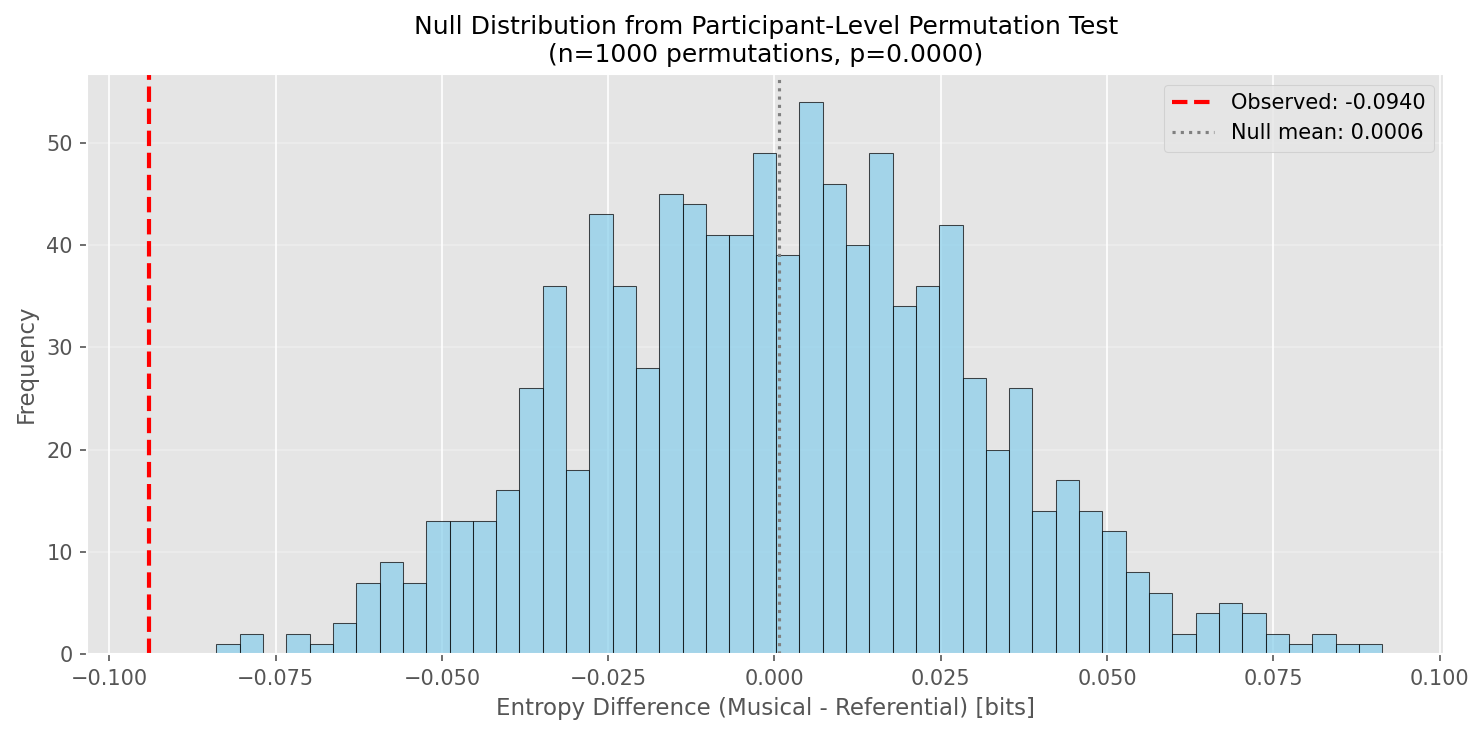

In [106]:
# Participant-level permutation test for entropy difference
n_permutations = 1000
rng = np.random.default_rng(42)  # for reproducibility

# Organize data by participant and condition
participant_data = {}

# Collect musical and referential condition data by participant
for participant_id, trials in trials_by_participant.items():
    if participant_id not in participant_data:
        participant_data[participant_id] = {'musical': [], 'referential': []}
    
    for trial in trials:
        condition = trial.get('session_info', {}).get('condition')
        
        for performance in trial.get('performances', []):
            for event in performance.get('interactions', []):
                if event.get('type') == 'mousemove':
                    x = event.get('x')
                    y = event.get('y')
                    if x is not None and y is not None:
                        if condition == 'musical':
                            participant_data[participant_id]['musical'].append((x, y))
                        elif condition == 'referential':
                            participant_data[participant_id]['referential'].append((x, y))
for entry in musical_trials:
    participant_id = entry.get('participant')
    if participant_id not in participant_data:
        participant_data[participant_id] = {'musical': [], 'referential': []}
    
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    participant_data[participant_id]['musical'].append((x, y))

# Collect referential condition data by participant
for entry in referential_trials:
    participant_id = entry.get('participant')
    if participant_id not in participant_data:
        participant_data[participant_id] = {'musical': [], 'referential': []}
    
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    participant_data[participant_id]['referential'].append((x, y))

print(f"Number of participants: {len(participant_data)}")
print(f"Participants with musical data: {sum(1 for p in participant_data.values() if len(p['musical']) > 0)}")
print(f"Participants with referential data: {sum(1 for p in participant_data.values() if len(p['referential']) > 0)}")

def compute_heatmaps_from_participant_data(participant_conditions, participant_data, 
                                           heatmap_resolution=10, canvas_size=400):
    """
    Compute heatmaps given participant condition assignments.
    
    participant_conditions: dict mapping participant_id -> 'musical' or 'referential' 
                           (which condition their data should be assigned to)
    """
    hm_mus = np.zeros((heatmap_resolution, heatmap_resolution))
    hm_ref = np.zeros((heatmap_resolution, heatmap_resolution))
    
    for pid, assigned_condition in participant_conditions.items():
        # Get the participant's original data from both conditions
        musical_moves = participant_data[pid]['musical']
        referential_moves = participant_data[pid]['referential']
        
        # Assign ALL of this participant's data to one condition
        if assigned_condition == 'musical':
            all_moves = musical_moves + referential_moves
            for x, y in all_moves:
                x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                hm_mus[y_bin, x_bin] += 1
        else:  # referential
            all_moves = musical_moves + referential_moves
            for x, y in all_moves:
                x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                hm_ref[y_bin, x_bin] += 1
    
    # Normalize
    if np.sum(hm_mus) > 0:
        hm_mus /= np.sum(hm_mus)
    if np.sum(hm_ref) > 0:
        hm_ref /= np.sum(hm_ref)
    
    # Compute entropies
    ent_mus = compute_entropy(hm_mus)
    ent_ref = compute_entropy(hm_ref)
    
    return ent_mus - ent_ref

# Observed difference (already computed in previous cell)
observed_diff = entropy_musical - entropy_referential

# Get list of participants
participant_ids = list(participant_data.keys())
n_participants = len(participant_ids)

print(f"\nRunning {n_permutations} participant-level permutations...")

# Generate null distribution
null_distribution = np.zeros(n_permutations)
for i in tqdm(range(n_permutations)):
    # Randomly assign participants to conditions (50/50 split)
    shuffled_conditions = rng.choice(['musical', 'referential'], size=n_participants, replace=True)
    participant_conditions = dict(zip(participant_ids, shuffled_conditions))
    
    # Compute entropy difference for shuffled assignment
    null_distribution[i] = compute_heatmaps_from_participant_data(
        participant_conditions, participant_data, heatmap_resolution, canvas_size
    )
    
    if (i + 1) % 1000 == 0:
        print(f'  Permutation {i+1}/{n_permutations}')

# Compute p-value (two-tailed)
p_value = np.mean(np.abs(null_distribution) >= np.abs(observed_diff))

print(f'\n{"="*60}')
print(f'PERMUTATION TEST RESULTS (Participant-Level)')
print(f'{"="*60}')
print(f'Observed entropy difference: {observed_diff:.4f} bits')
print(f'Null distribution mean: {np.mean(null_distribution):.4f} bits')
print(f'Null distribution std: {np.std(null_distribution):.4f} bits')
print(f'Two-tailed p-value: {p_value:.4f}')
print(f'Significant at α=0.05: {"Yes" if p_value < 0.05 else "No"}')
print(f'Significant at α=0.01: {"Yes" if p_value < 0.01 else "No"}')
print(f'Standardized effect size: {observed_diff / np.std(null_distribution):.3f} SD')
print(f'{"="*60}')

# Visualize null distribution
plt.figure(figsize=(10, 5), dpi=150)
plt.hist(null_distribution, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, label=f'Observed: {observed_diff:.4f}')
plt.axvline(np.mean(null_distribution), color='gray', linestyle=':', linewidth=1.5, label=f'Null mean: {np.mean(null_distribution):.4f}')
plt.xlabel('Entropy Difference (Musical - Referential) [bits]', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'Null Distribution from Participant-Level Permutation Test\n(n={n_permutations} permutations, p={p_value:.4f})', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

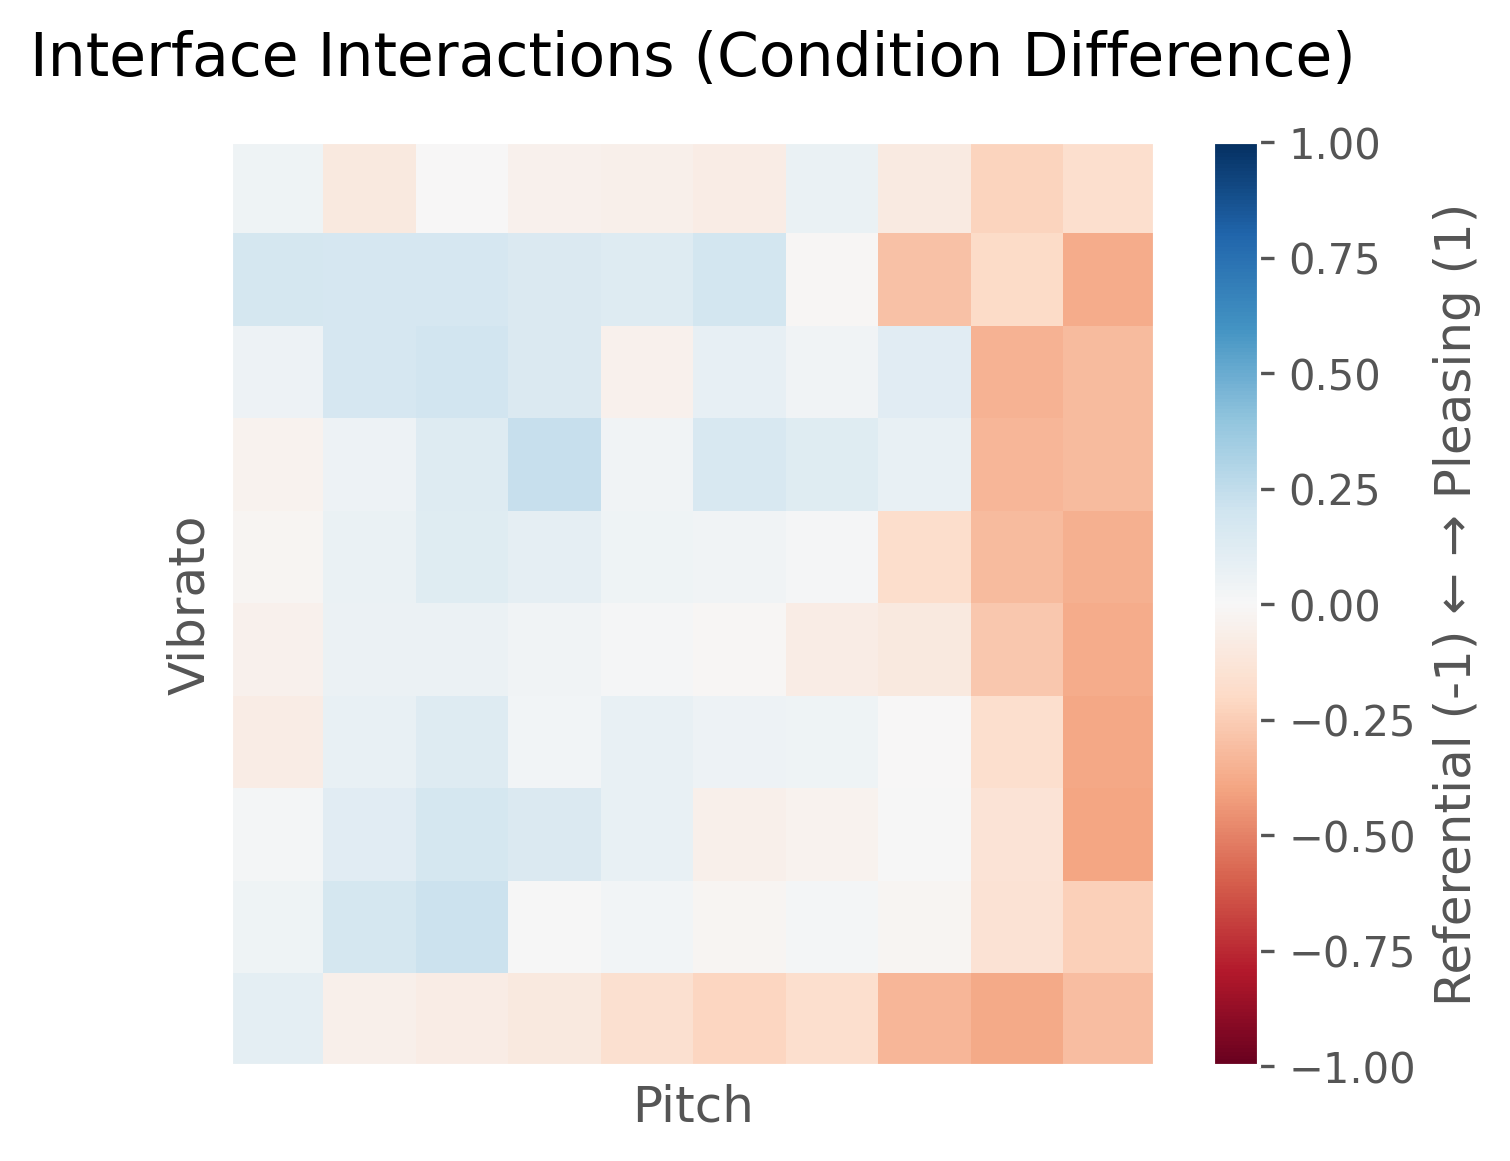

In [ ]:
# difference heatmap normalized by total usage
difference_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
for i in range(heatmap_resolution):
    for j in range(heatmap_resolution):
        total = musical_heatmap[i, j] + referential_heatmap[i, j]
        if total > 0:
            difference_heatmap[i, j] = (musical_heatmap[i, j] - referential_heatmap[i, j]) / total
        else:
            difference_heatmap[i, j] = 0

plt.figure(figsize=(5,4), dpi=300)
plt.imshow(difference_heatmap, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(label='Referential (-1) ← → Pleasing (1)')
plt.title('Interface Interactions (Condition Difference)', pad=16)
plt.xticks([])
plt.yticks([])
plt.xlabel('Pitch')
plt.ylabel('Vibrato')
plt.show()

In [107]:
corr = np.corrcoef(referential_heatmap.flatten(), musical_heatmap.flatten())[0, 1]
print(f'Correlation between heatmaps: r = {corr:.3f}')

Correlation between heatmaps: r = 0.860


In [108]:
# permutation test: compare heatmap distributions with participant-level label shuffling
def build_heatmap(trials):
    heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
    for entry in trials:
        if not isinstance(entry, dict):
            continue
        for performance in entry.get('performances', []):
            for event in performance.get('interactions', []):
                if event.get('type') == 'mousemove':
                    x = event.get('x')
                    y = event.get('y')
                    if x is not None and y is not None:
                        x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                        y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                        heatmap[y_bin, x_bin] += 1
    total = heatmap.sum()
    return heatmap / total if total > 0 else heatmap

def heatmap_distance(h1, h2):
    return np.sum(np.abs(h1 - h2))

# observed statistic
observed_stat = heatmap_distance(musical_heatmap, referential_heatmap)

trials_by_participant = {}
rng = np.random.default_rng(0)

for entry in data:
    if not isinstance(entry, dict):
        continue
    pid = entry.get('prolific', {}).get('prolificSessionID')
    if pid is not None:
        trials_by_participant.setdefault(pid, []).append(entry)

participant_ids = list(trials_by_participant.keys())

# permutations
n_permutations = 10000
null_stats = []

for _ in tqdm(range(n_permutations)):
    shuffled_musical = []
    shuffled_referential = []
    for pid in participant_ids:
        if rng.random() < 0.5:
            shuffled_musical.extend(trials_by_participant[pid])
        else:
            shuffled_referential.extend(trials_by_participant[pid])
    hm_mus = build_heatmap(shuffled_musical)
    hm_ref = build_heatmap(shuffled_referential)
    null_stats.append(heatmap_distance(hm_mus, hm_ref))

null_stats = np.array(null_stats)
p_value = np.mean(null_stats >= observed_stat)

print(f'Observed heatmap distance (L1): {observed_stat:.6f}')
print(f'Permutation test p-value: {p_value:.4f}')

100%|██████████| 10000/10000 [00:00<00:00, 204106.36it/s]

Observed heatmap distance (L1): 0.224870
Permutation test p-value: 0.0000


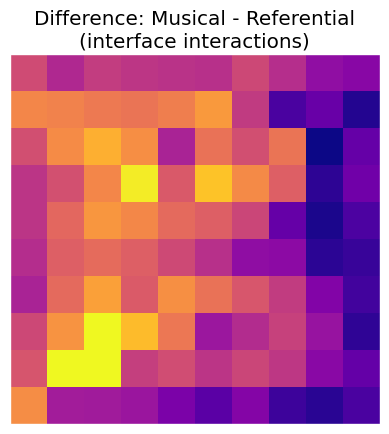

In [29]:
plt.imshow(musical_heatmap - referential_heatmap, cmap='plasma', interpolation='nearest')
plt.title('Difference: Musical - Referential\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.show()

### pitch space and vibrato space distributions

In [30]:
print(f'number of musical interactions: {len(musical_xvals)}')
print(f'number of referential interactions: {len(referential_xvals)}')

number of musical interactions: 169322
number of referential interactions: 188287


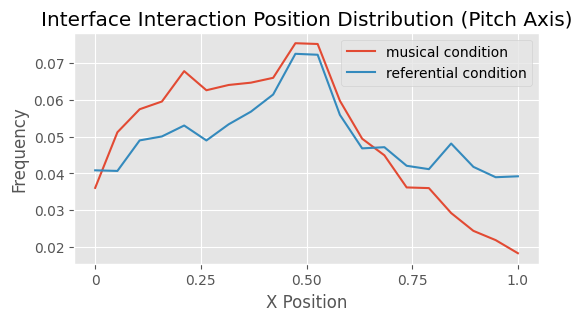

In [82]:
plt.figure(figsize=(6,3))
musical_pitch_hist = np.histogram(musical_xvals, bins=20, range=(0, canvas_size))
plt.plot(musical_pitch_hist[1][:-1], musical_pitch_hist[0]/len(musical_xvals), label='musical condition')
referential_pitch_hist = np.histogram(referential_xvals, bins=20, range=(0, canvas_size))
plt.plot(referential_pitch_hist[1][:-1], referential_pitch_hist[0]/len(referential_xvals), label='referential condition')
plt.xlabel('X Position')
plt.ylabel('Frequency')
plt.xticks(np.linspace(0, 380, 5), ['0', '0.25', '0.50', '0.75', '1.0'])
plt.title('Interface Interaction Position Distribution (Pitch Axis)')
plt.legend()
plt.show()

In [32]:
# compute 1D Earth Mover's Distance (Wasserstein) between x-position distributions
emd_x = stats.wasserstein_distance(musical_xvals, referential_xvals)
print(f'earth mover distance (pitch axis, pixels): {emd_x:.3f}')

earth mover distance (pitch axis, pixels): 20.510


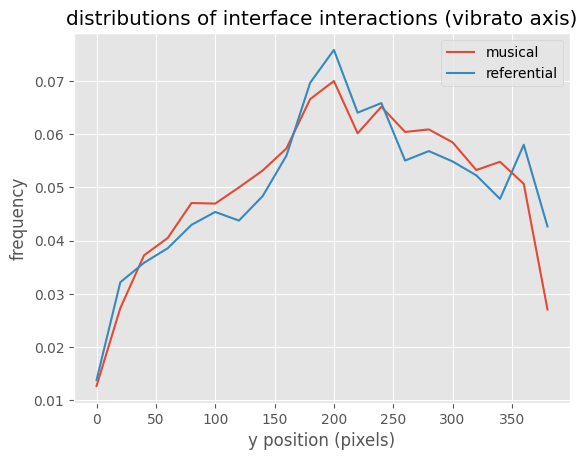

In [33]:
musical_vibrato_hist = np.histogram(musical_yvals, bins=20, range=(0, canvas_size))
plt.plot(musical_vibrato_hist[1][:-1], musical_vibrato_hist[0]/len(musical_yvals), label='musical')
referential_vibrato_hist = np.histogram(referential_yvals, bins=20, range=(0, canvas_size))
plt.plot(referential_vibrato_hist[1][:-1], referential_vibrato_hist[0]/len(referential_yvals), label='referential')
plt.xlabel('y position (pixels)')
plt.ylabel('frequency')
plt.title('distributions of interface interactions (vibrato axis)')
plt.legend()
plt.show()

In [34]:
# compute 1D Earth Mover's Distance (Wasserstein) between y-position distributions
emd_y = stats.wasserstein_distance(musical_yvals, referential_yvals)
print(f'earth mover distance (vibrato axis, pixels): {emd_y:.3f}')

earth mover distance (vibrato axis, pixels): 3.389


### shuffle participant labels for null distribution

In [35]:
n_shuffles = 200

In [36]:
x_EMDs = []
y_EMDs = []

for _ in tqdm(range(n_shuffles)):
    crossgroup_shuffled_participants = [[],[]]
    for trial in data:
        random_group = np.random.choice([0, 1])
        crossgroup_shuffled_participants[random_group].append(trial)

    shuffled_xvals_0 = []
    shuffled_xvals_1 = []
    shuffled_yvals_0 = []
    shuffled_yvals_1 = []
    
    for group in crossgroup_shuffled_participants:
        for entry in group:
            for performance in entry.get('performances', []):
                for event in performance.get('interactions', []):
                    if event.get('type') == 'mousemove':
                        x = event.get('x')
                        y = event.get('y')
                        if x is not None:
                            if group == crossgroup_shuffled_participants[0]:
                                shuffled_xvals_0.append(x)
                                shuffled_yvals_0.append(y)
                            else:
                                shuffled_xvals_1.append(x)
                                shuffled_yvals_1.append(y)
    
    x_EMD = stats.wasserstein_distance(shuffled_xvals_0, shuffled_xvals_1)
    x_EMDs.append(x_EMD)
    y_EMD = stats.wasserstein_distance(shuffled_yvals_0, shuffled_yvals_1)
    y_EMDs.append(y_EMD)

100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


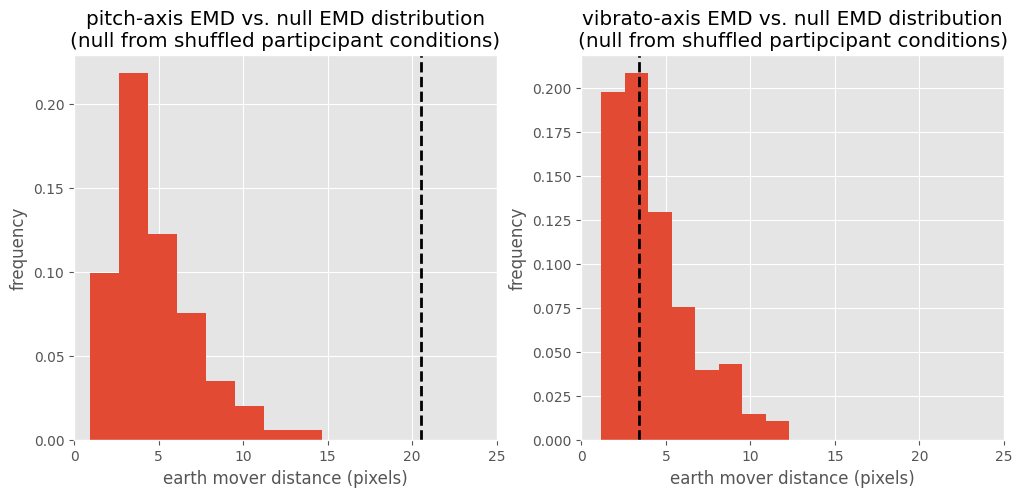

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(x_EMDs, bins=8, density=True)
plt.axvline(emd_x, color='k', linestyle='dashed', linewidth=2)
plt.title('pitch-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.xlim([0, 25])
plt.subplot(1,2,2)
plt.hist(y_EMDs, bins=8, density=True)
plt.axvline(emd_y, color='k', linestyle='dashed', linewidth=2)
plt.title('vibrato-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.xlim([0, 25])
plt.show()

In [38]:
# p-values comparing observed EMDs to null distributions
p_pitch = np.mean(np.array(x_EMDs) >= emd_x)
p_vibrato = np.mean(np.array(y_EMDs) >= emd_y)

print(f'Pitch-axis EMD p-value: {p_pitch:.4f}')
print(f'Vibrato-axis EMD p-value: {p_vibrato:.4f}')

Pitch-axis EMD p-value: 0.0000
Vibrato-axis EMD p-value: 0.5300


### let's look at some other statistics per-sound

In [39]:
def calculate_curvature(x_coords, y_coords):
    """Calculate arc-length weighted average curvature from position data"""
    if len(x_coords) < 3:
        return 0.0
    
    curvatures = []
    arc_lengths = []
    
    for i in range(1, len(x_coords) - 1):
        # Get three consecutive points
        x1, y1 = x_coords[i-1], y_coords[i-1]
        x2, y2 = x_coords[i], y_coords[i]
        x3, y3 = x_coords[i+1], y_coords[i+1]
        
        # Calculate area of triangle formed by three points
        area = abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1)) / 2.0
        
        # Calculate side lengths
        a = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        b = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        c = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        # Calculate arc length between adjacent points
        arc_length = (a + c) / 2.0
        
        # Calculate curvature using Menger curvature
        if a * b * c > 0 and arc_length > 0:
            curvature = 4 * area / (a * b * c)
            curvatures.append(curvature)
            arc_lengths.append(arc_length)
    
    # Calculate weighted average
    if sum(arc_lengths) > 0:
        avg_curvature = np.average(curvatures, weights=arc_lengths)
        return avg_curvature
    return 0.0

musical_performance_stats = []
referential_performance_stats = []

for entry in musical_trials:
    for performance in entry.get('performances', []):
        x_positions = []
        y_positions = []
        
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_positions.append(x)
                    y_positions.append(y)
        
        if len(x_positions) > 0:
            # Calculate standard deviation of positions
            all_positions = np.array(list(zip(x_positions, y_positions)))
            std_pos = np.std(all_positions)
            
            # Calculate average curvature
            avg_curvature = calculate_curvature(x_positions, y_positions)

            avg_velo_x = x_positions[-1] - x_positions[0]
            avg_velo_y = y_positions[-1] - y_positions[0]
            
            musical_performance_stats.append({
                'std_pos': std_pos,
                'avg_curvature': avg_curvature,
                'avg_velo_x': avg_velo_x,
                'avg_velo_y': avg_velo_y
            })

for entry in referential_trials:
    for performance in entry.get('performances', []):
        x_positions = []
        y_positions = []
        
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_positions.append(x)
                    y_positions.append(y)
        
        if len(x_positions) > 0:
            # Calculate standard deviation of positions
            all_positions = np.array(list(zip(x_positions, y_positions)))
            std_pos = np.std(all_positions)
            
            # Calculate average curvature
            avg_curvature = calculate_curvature(x_positions, y_positions)

            avg_velo_x = x_positions[-1] - x_positions[0]
            avg_velo_y = y_positions[-1] - y_positions[0]
            
            referential_performance_stats.append({
                'std_pos': std_pos,
                'avg_curvature': avg_curvature,
                'avg_velo_x': avg_velo_x,
                'avg_velo_y': avg_velo_y
            })

print(f'Musical performances: {len(musical_performance_stats)}')
print(f'Referential performances: {len(referential_performance_stats)}')

Musical performances: 1534
Referential performances: 1659


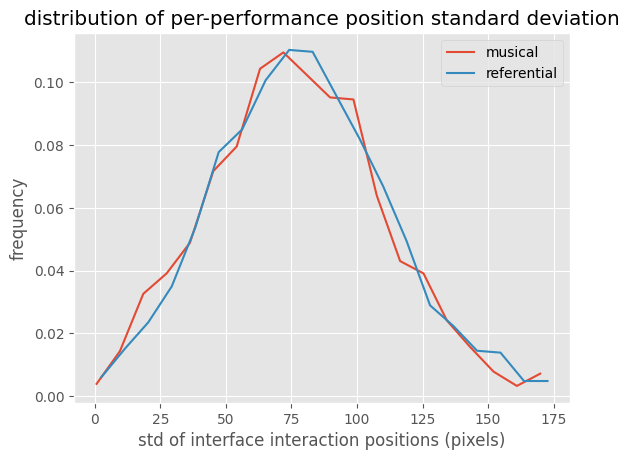

In [40]:
musical_std = np.histogram([performance.get('std_pos') for performance in musical_performance_stats], bins=20)
referential_std = np.histogram([performance.get('std_pos') for performance in referential_performance_stats], bins=20)

plt.plot(musical_std[1][:-1], musical_std[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_std[1][:-1], referential_std[0]/len(referential_performance_stats), label='referential')
plt.xlabel('std of interface interaction positions (pixels)')
plt.ylabel('frequency')
plt.title('distribution of per-performance position standard deviation')
plt.legend()
plt.show()

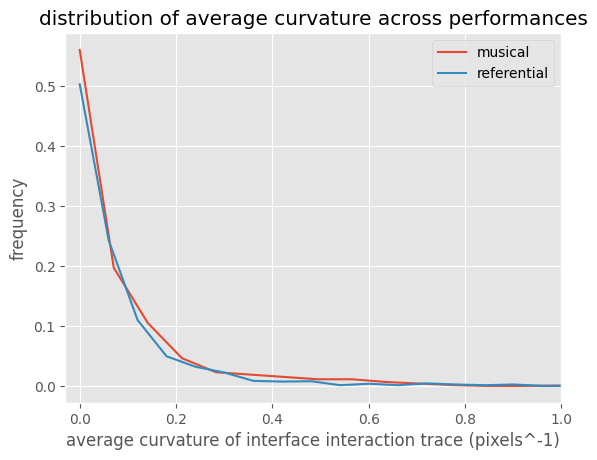

In [41]:
musical_curvature = np.histogram([performance.get('avg_curvature') for performance in musical_performance_stats], bins=20)
referential_curvature = np.histogram([performance.get('avg_curvature') for performance in referential_performance_stats], bins=20)
plt.plot(musical_curvature[1][:-1], musical_curvature[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_curvature[1][:-1], referential_curvature[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average curvature of interface interaction trace (pixels^-1)')
plt.ylabel('frequency')
plt.title('distribution of average curvature across performances')
plt.xlim([-0.03, 1])
plt.legend()
plt.show()

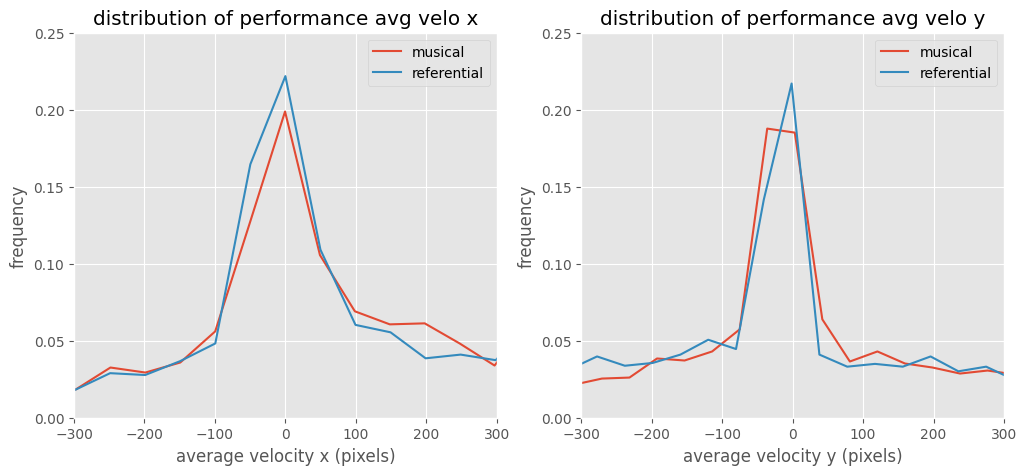

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
musical_velo_x = np.histogram([performance.get('avg_velo_x') for performance in musical_performance_stats], bins=16)
referential_velo_x = np.histogram([performance.get('avg_velo_x') for performance in referential_performance_stats], bins=16)
plt.plot(musical_velo_x[1][:-1], musical_velo_x[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_velo_x[1][:-1], referential_velo_x[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average velocity x (pixels)')
plt.ylabel('frequency')
plt.title('distribution of performance avg velo x')
plt.xlim([-300, 300])
plt.ylim([0, 0.25])
plt.legend()

plt.subplot(1, 2, 2)
musical_velo_y = np.histogram([performance.get('avg_velo_y') for performance in musical_performance_stats], bins=20)
referential_velo_y = np.histogram([performance.get('avg_velo_y') for performance in referential_performance_stats], bins=20)
plt.plot(musical_velo_y[1][:-1], musical_velo_y[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_velo_y[1][:-1], referential_velo_y[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average velocity y (pixels)')
plt.ylabel('frequency')
plt.title('distribution of performance avg velo y')
plt.xlim([-300, 300])
plt.ylim([0, 0.25])
plt.legend()

plt.show()

In [43]:
# Calculate means for referential performance stats
referential_means = {
    'std_pos': np.mean([p['std_pos'] for p in referential_performance_stats]),
    'avg_curvature': np.mean([p['avg_curvature'] for p in referential_performance_stats]),
    'avg_velo_x': np.mean([p['avg_velo_x'] for p in referential_performance_stats]),
    'avg_velo_y': np.mean([p['avg_velo_y'] for p in referential_performance_stats])
}

# Calculate means for musical performance stats
musical_means = {
    'std_pos': np.mean([p['std_pos'] for p in musical_performance_stats]),
    'avg_curvature': np.mean([p['avg_curvature'] for p in musical_performance_stats]),
    'avg_velo_x': np.mean([p['avg_velo_x'] for p in musical_performance_stats]),
    'avg_velo_y': np.mean([p['avg_velo_y'] for p in musical_performance_stats])
}

print('referential condition stats (averaged across all performances):')
for key, value in referential_means.items():
    print(f'  {key}: {value:.3f}')

print('\nmusical condition stats (averaged across all performances):')
for key, value in musical_means.items():
    print(f'  {key}: {value:.3f}')

referential condition stats (averaged across all performances):
  std_pos: 83.538
  avg_curvature: 0.101
  avg_velo_x: 38.128
  avg_velo_y: -6.600

musical condition stats (averaged across all performances):
  std_pos: 81.463
  avg_curvature: 0.109
  avg_velo_x: 41.450
  avg_velo_y: 5.722


## trace feature analysis

In [44]:
def extract_trace_features(trace_array):
    '''
    Extract center of mass x, center of mass y, std x, std y, and curvature from a trace given as an array of (x,y,t)
    '''
    features = {}
    if len(trace_array) == 0:
        return features
    x_coords = [point[0] for point in trace_array]
    y_coords = [point[1] for point in trace_array]
    features['com_x'] = np.mean(x_coords)
    features['com_y'] = np.mean(y_coords)
    features['std_x'] = np.std(x_coords)
    features['std_y'] = np.std(y_coords)
    features['curvature'] = calculate_curvature(x_coords, y_coords)
    return features

In [45]:
# convert data to list of performances represented as {particpant_id, condition, animated_attribute, animated_attribute_vals, trace_features}
performances_data = []
for entry in tqdm(data):
    participant_id = entry.get('prolific').get('prolificSessionID')
    condition = entry.get('session_info', {}).get('condition')
    animated_attribute = entry.get('animated_attribute')
    animated_attribute_vals = entry.get('animated_attribute_vals', [])
    for performance in entry.get('performances', []):
        trace_array = []
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                t = event.get('timestamp')
                if x is not None and y is not None and t is not None:
                    trace_array.append((x, y, t))
        trace_features = extract_trace_features(trace_array)
        performances_data.append({
            'participant_id': participant_id,
            'condition': condition,
            'stimulus': entry.get('session_info', {}).get('stimulus'),
            'animated_attribute': animated_attribute,
            'animated_attribute_vals': animated_attribute_vals,
            'trace_features': trace_features
        })


# normalize trace features using StandardScaler across all performances
scaler = StandardScaler()
all_features = []
for performance in performances_data:
    features = performance.get('trace_features', {})
    feature_vector = [
        features.get('com_x', 0),
        features.get('com_y', 0),
        features.get('std_x', 0),
        features.get('std_y', 0),
        features.get('curvature', 0)
    ]
    all_features.append(feature_vector)
all_features = np.array(all_features)
scaled_features = scaler.fit_transform(all_features)
for i, performance in enumerate(performances_data):
    performance['trace_features_scaled'] = {
        'com_x': scaled_features[i, 0],
        'com_y': scaled_features[i, 1],
        'std_x': scaled_features[i, 2],
        'std_y': scaled_features[i, 3],
        'curvature': scaled_features[i, 4]
    }

100%|██████████| 2344/2344 [00:00<00:00, 2931.48it/s]


In [46]:
# group performances by participant (data structure: {participant_id: [features]})
# also track each participant's condition and stimulus
performances_by_participant = {}
participant_conditions = {}
participant_stimuli = {}

for performance in performances_data:
    participant_id = performance.get('participant_id')
    condition = performance.get('condition')
    stimulus = performance.get('stimulus')
    features = performance.get('trace_features_scaled', {})
    
    if participant_id not in performances_by_participant:
        performances_by_participant[participant_id] = []
        participant_conditions[participant_id] = condition
        participant_stimuli[participant_id] = stimulus
    
    performances_by_participant[participant_id].append(features)

In [47]:
# for each participant, calculate mean pairwise distance between performances
mean_pairwise_distances_by_participant = {}
for participant_id, features_list in performances_by_participant.items():
    n = len(features_list)
    if n < 2:
        continue
    pairwise_distances = []
    for i in range(n):
        for j in range(i + 1, n):
            feat_i = np.array(list(features_list[i].values()))
            feat_j = np.array(list(features_list[j].values()))
            distance = np.linalg.norm(feat_i - feat_j)
            pairwise_distances.append(distance)
    mean_distance = np.mean(pairwise_distances)
    mean_pairwise_distances_by_participant[participant_id] = {
        'distance': mean_distance,
        'condition': participant_conditions[participant_id],
        'stimulus': participant_stimuli[participant_id]
    }

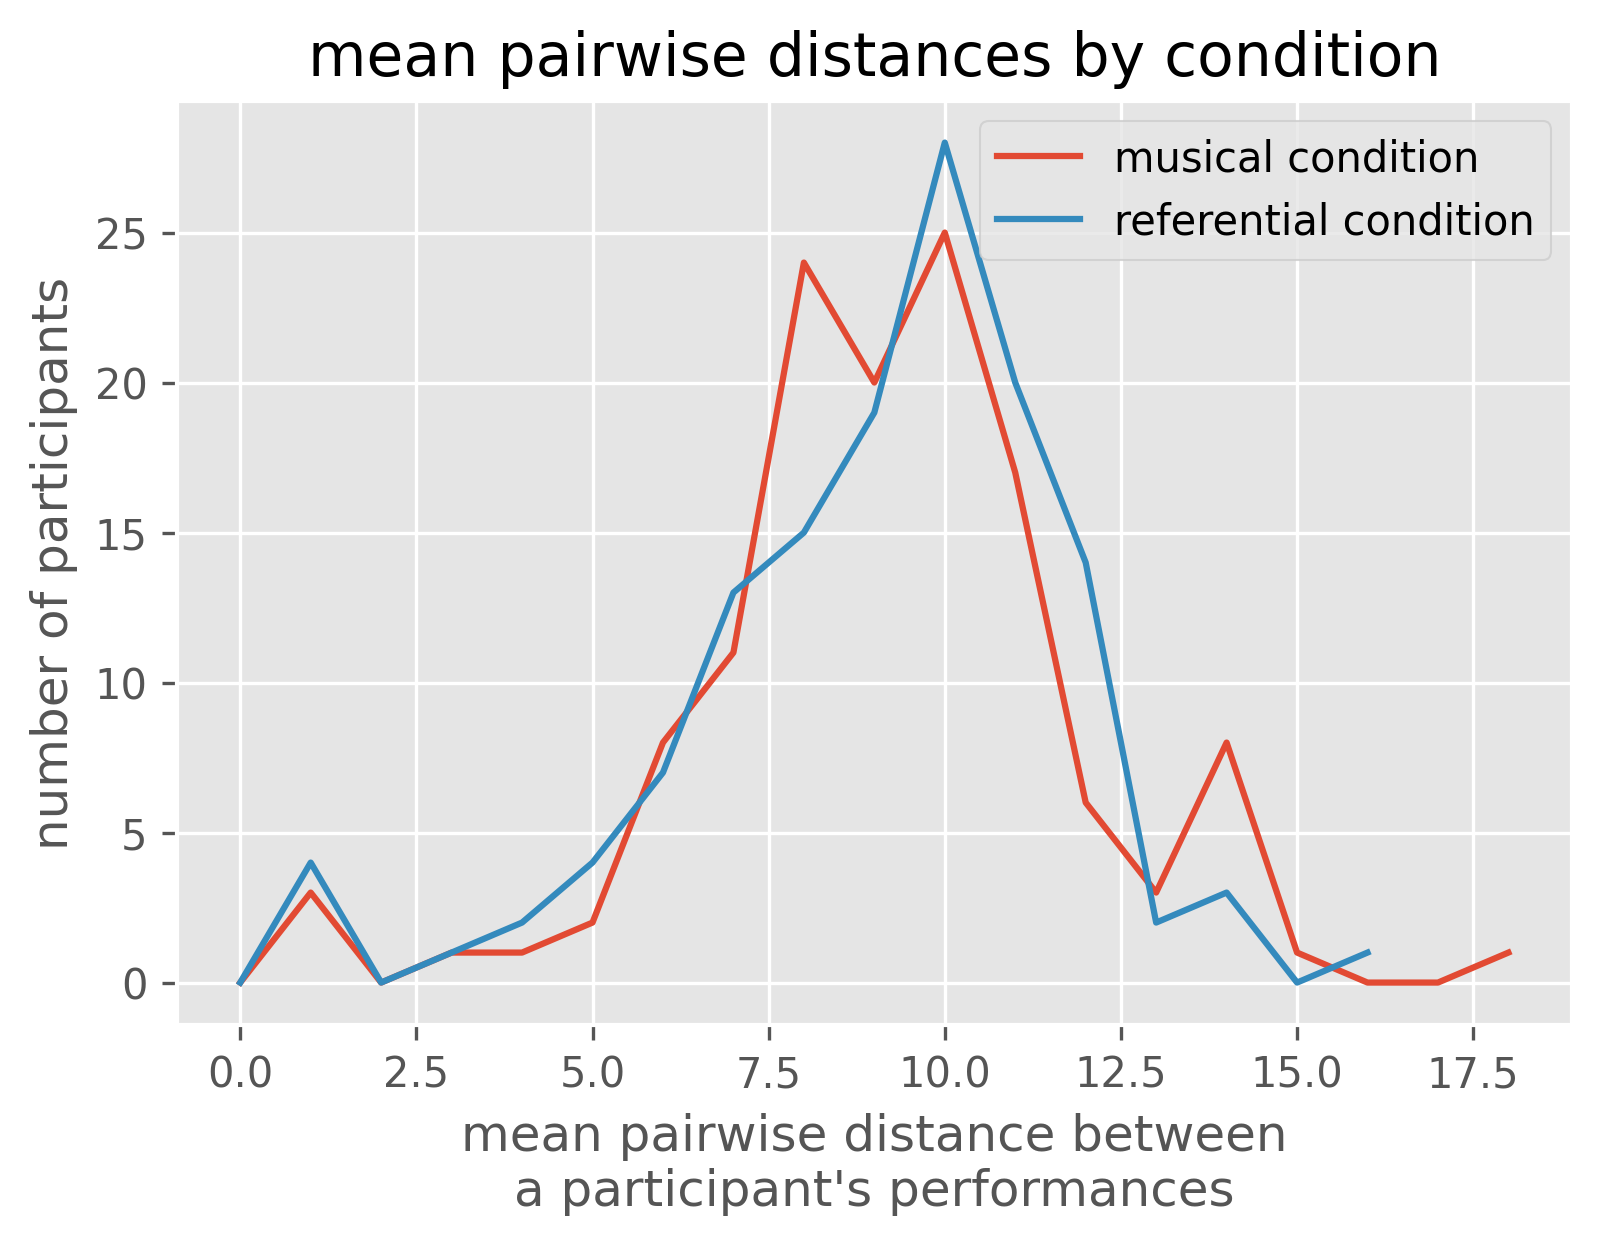

In [48]:
# visualize distribution of mean pairwise distances by condition
musical_distances = [v['distance'] for k, v in mean_pairwise_distances_by_participant.items() if v['condition'] == 'musical']
referential_distances = [v['distance'] for k, v in mean_pairwise_distances_by_participant.items() if v['condition'] == 'referential']

bins = np.linspace(0, 5, 20)
musical_distances_binned = np.bincount(np.digitize(musical_distances, bins=bins))
referential_distances_binned = np.bincount(np.digitize(referential_distances, bins=bins))

plt.figure(figsize=(6,4), dpi=300)
plt.plot(musical_distances_binned, label='musical condition')
plt.plot(referential_distances_binned, label='referential condition')
plt.xlabel('mean pairwise distance between\na participant\'s performances')
plt.ylabel('number of participants')
plt.title('mean pairwise distances by condition')
plt.legend()
plt.show()

In [49]:
# find the means of the distributions and p-value using t-test
musical_mean_distance = np.mean(musical_distances)
referential_mean_distance = np.mean(referential_distances)
t_stat, p_value = stats.ttest_ind(musical_distances, referential_distances, equal_var=False)
print(f'Musical condition mean pairwise distance: {musical_mean_distance:.3f}')
print(f'Referential condition mean pairwise distance: {referential_mean_distance:.3f}')
print(f't-test p-value: {p_value:.3f}')

Musical condition mean pairwise distance: 2.289
Referential condition mean pairwise distance: 2.257
t-test p-value: 0.708


### segmented by stimulus

In [50]:
pairwise_distances_by_stimulus = { 'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': [], 'G': [], 'H': [] }

for participant_id, data in mean_pairwise_distances_by_participant.items():
    stimulus = data['stimulus']
    distance = data['distance']
    pairwise_distances_by_stimulus[stimulus].append(distance)

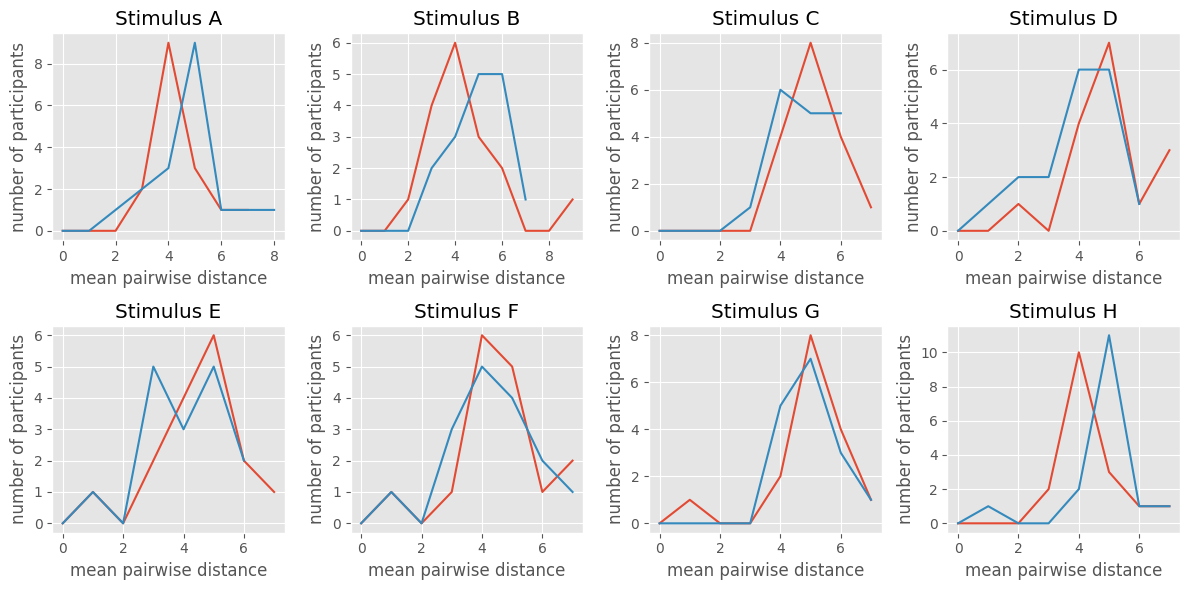

In [51]:
# 8 subplots, one for each stimulus
plt.figure(figsize=(12, 6))
for i, (stimulus, distances) in enumerate(pairwise_distances_by_stimulus.items()):
    # visualize distribution of mean pairwise distances by condition
    plt.subplot(2, 4, i + 1)
    musical_distances = [d for participant_id, d in zip(mean_pairwise_distances_by_participant.keys(), mean_pairwise_distances_by_participant.values()) if mean_pairwise_distances_by_participant[participant_id]['condition'] == 'musical' and mean_pairwise_distances_by_participant[participant_id]['stimulus'] == stimulus]
    referential_distances = [d for participant_id, d in zip(mean_pairwise_distances_by_participant.keys(), mean_pairwise_distances_by_participant.values()) if mean_pairwise_distances_by_participant[participant_id]['condition'] == 'referential' and mean_pairwise_distances_by_participant[participant_id]['stimulus'] == stimulus]
    bins = np.linspace(0, 5, 10)
    musical_distances_binned = np.bincount(np.digitize([d['distance'] for d in musical_distances], bins=bins))
    referential_distances_binned = np.bincount(np.digitize([d['distance'] for d in referential_distances], bins=bins))
    plt.plot(musical_distances_binned, label='musical condition')
    plt.plot(referential_distances_binned, label='referential condition')
    plt.title(f'Stimulus {stimulus}')
    plt.xlabel('mean pairwise distance')
    plt.ylabel('number of participants')
    # plt.legend()
plt.tight_layout()
plt.show()

In [52]:
for stimulus, distances in pairwise_distances_by_stimulus.items():
    musical_distances = [d['distance'] for participant_id, d in zip(mean_pairwise_distances_by_participant.keys(), mean_pairwise_distances_by_participant.values()) if mean_pairwise_distances_by_participant[participant_id]['condition'] == 'musical' and mean_pairwise_distances_by_participant[participant_id]['stimulus'] == stimulus]
    referential_distances = [d['distance'] for participant_id, d in zip(mean_pairwise_distances_by_participant.keys(), mean_pairwise_distances_by_participant.values()) if mean_pairwise_distances_by_participant[participant_id]['condition'] == 'referential' and mean_pairwise_distances_by_participant[participant_id]['stimulus'] == stimulus]
    if len(musical_distances) > 1 and len(referential_distances) > 1:
        t_stat, p_value = stats.ttest_ind(musical_distances, referential_distances, equal_var=False)
        print(f'Stimulus {stimulus} t-test p-value: {p_value:.3f} \t {"not" if p_value > 0.05 else ""} significant')

Stimulus A t-test p-value: 0.602 	 not significant
Stimulus B t-test p-value: 0.180 	 not significant
Stimulus C t-test p-value: 0.234 	 not significant
Stimulus D t-test p-value: 0.080 	 not significant
Stimulus E t-test p-value: 0.520 	 not significant
Stimulus F t-test p-value: 0.877 	 not significant
Stimulus G t-test p-value: 0.904 	 not significant
Stimulus H t-test p-value: 0.291 	 not significant


### Pairwise distances from the cue's perspective

Now analyzing from the perspective of each cue (amoeba): for each cue, compute the mean pairwise distance between performances from different participants who saw that cue. This measures how diverse the responses were to a particular cue across participants.

In [53]:
# Group performances by cue (animated_attribute + animated_attribute_vals)
# Each cue has performances from multiple participants in both conditions
performances_by_cue = {}

for performance in performances_data:
    participant_id = performance.get('participant_id')
    condition = performance.get('condition')
    animated_attribute = performance.get('animated_attribute')
    animated_attribute_vals = performance.get('animated_attribute_vals')
    
    # Skip if missing critical data
    if animated_attribute is None or animated_attribute_vals is None:
        continue
    
    # Convert to tuple for hashability
    animated_attribute_vals = tuple(animated_attribute_vals)
    features = performance.get('trace_features_scaled', {})
    
    # Create unique cue identifier
    cue_id = (animated_attribute, animated_attribute_vals)
    
    if cue_id not in performances_by_cue:
        performances_by_cue[cue_id] = {'musical': [], 'referential': []}
    
    # Store performance with participant info
    performances_by_cue[cue_id][condition].append({
        'participant_id': participant_id,
        'features': features
    })

print(f'Found {len(performances_by_cue)} unique cues')

Found 18 unique cues


In [54]:
# For each cue, calculate mean pairwise distance across different participants
mean_pairwise_distances_by_cue = {}

for cue_id, cue_data in tqdm(performances_by_cue.items()):
    for condition in ['musical', 'referential']:
        performances = cue_data[condition]
        
        if len(performances) < 2:
            continue
        
        # Calculate pairwise distances between different participants' performances
        pairwise_distances = []
        for i in range(len(performances)):
            for j in range(i + 1, len(performances)):
                # Ensure we're comparing different participants
                if performances[i]['participant_id'] != performances[j]['participant_id']:
                    feat_i = np.array(list(performances[i]['features'].values()))
                    feat_j = np.array(list(performances[j]['features'].values()))
                    distance = np.linalg.norm(feat_i - feat_j)
                    pairwise_distances.append(distance)
        
        if len(pairwise_distances) > 0:
            mean_distance = np.mean(pairwise_distances)
            
            # Store with cue_id and condition
            key = (cue_id, condition)
            mean_pairwise_distances_by_cue[key] = {
                'distance': mean_distance,
                'cue_id': cue_id,
                'condition': condition,
                'n_participants': len(performances)
            }

print(f'Computed distances for {len(mean_pairwise_distances_by_cue)} cue-condition pairs')

100%|██████████| 18/18 [00:00<00:00, 35.27it/s]

Computed distances for 36 cue-condition pairs


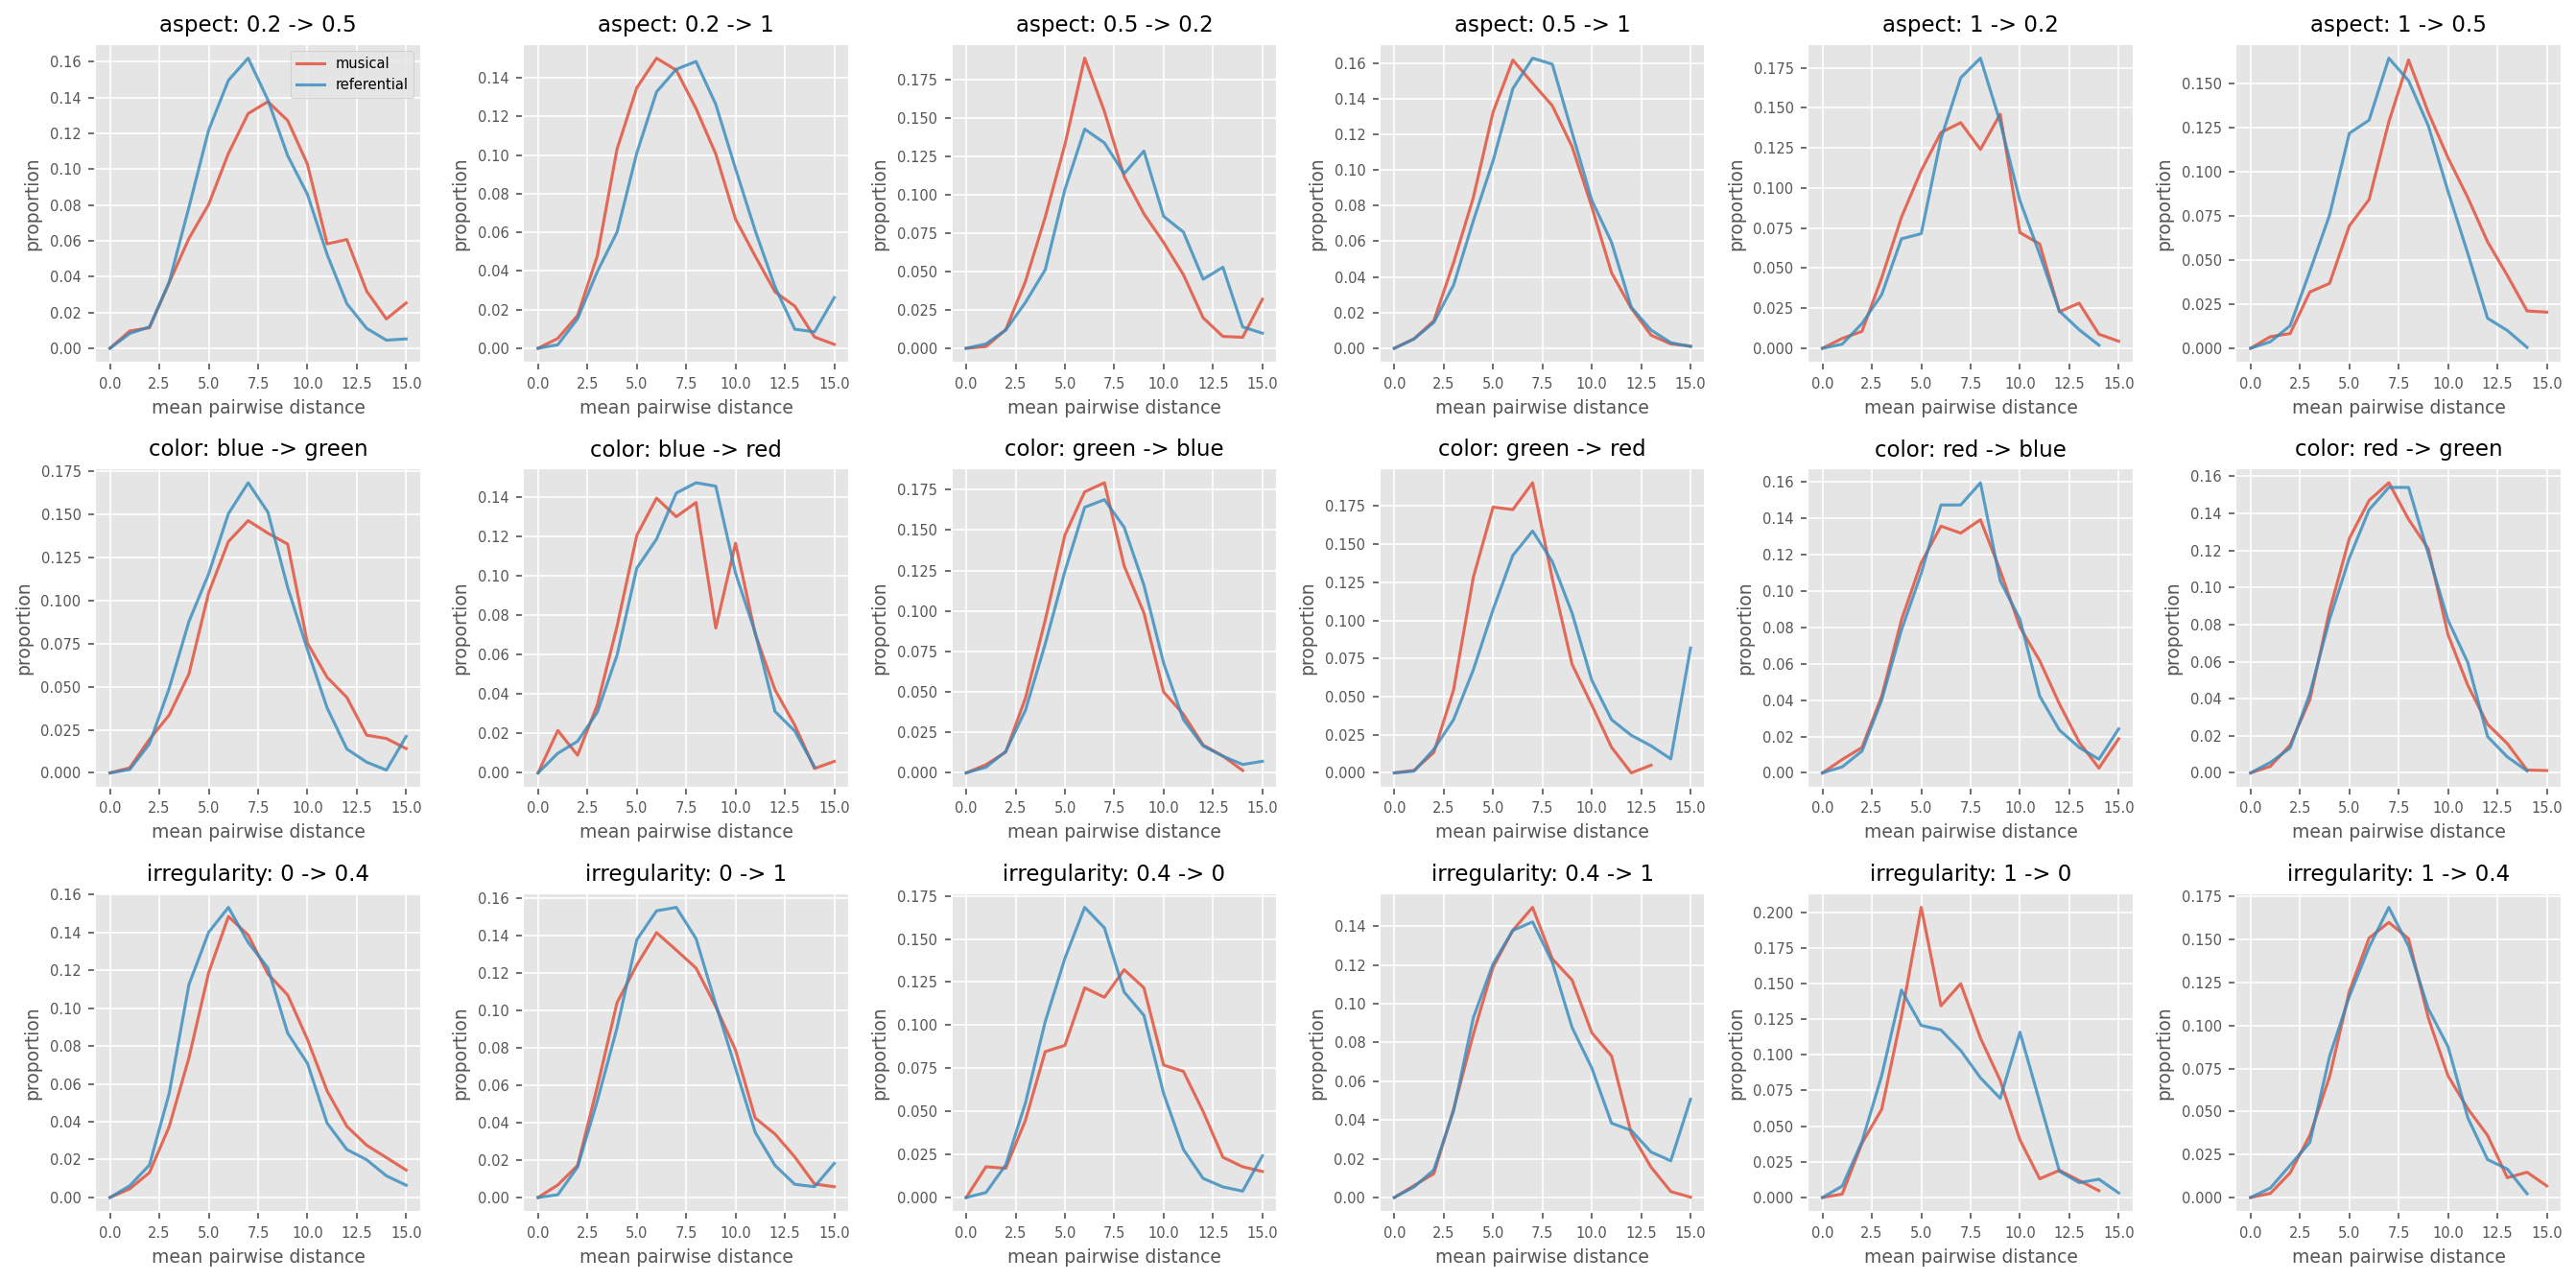

In [55]:
# Plot each of the 18 cues individually
plt.figure(figsize=(18, 9), dpi=150)

for idx, cue_id in enumerate(sorted(performances_by_cue.keys())):
    plt.subplot(3, 6, idx + 1)
    
    # Get distances for this cue by condition
    musical_key = (cue_id, 'musical')
    referential_key = (cue_id, 'referential')
    
    # Collect all distances for this cue across participants
    musical_distances_for_cue = []
    referential_distances_for_cue = []
    
    if musical_key in mean_pairwise_distances_by_cue:
        # For this cue, we only have one mean distance value (averaged across all participant pairs)
        # But to match the style, we can plot the distribution based on individual pairwise distances
        # Let's recalculate individual pairwise distances for this cue
        performances = performances_by_cue[cue_id]['musical']
        for i in range(len(performances)):
            for j in range(i + 1, len(performances)):
                if performances[i]['participant_id'] != performances[j]['participant_id']:
                    feat_i = np.array(list(performances[i]['features'].values()))
                    feat_j = np.array(list(performances[j]['features'].values()))
                    distance = np.linalg.norm(feat_i - feat_j)
                    musical_distances_for_cue.append(distance)
    
    if referential_key in mean_pairwise_distances_by_cue:
        performances = performances_by_cue[cue_id]['referential']
        for i in range(len(performances)):
            for j in range(i + 1, len(performances)):
                if performances[i]['participant_id'] != performances[j]['participant_id']:
                    feat_i = np.array(list(performances[i]['features'].values()))
                    feat_j = np.array(list(performances[j]['features'].values()))
                    distance = np.linalg.norm(feat_i - feat_j)
                    referential_distances_for_cue.append(distance)
    
    # Bin and plot
    bins = np.linspace(0, 6, 15)
    
    if len(musical_distances_for_cue) > 0:
        musical_binned = np.bincount(np.digitize(musical_distances_for_cue, bins=bins))
        plt.plot(musical_binned / np.sum(musical_binned), label='musical', alpha=0.8)
    
    if len(referential_distances_for_cue) > 0:
        referential_binned = np.bincount(np.digitize(referential_distances_for_cue, bins=bins))
        plt.plot(referential_binned / np.sum(referential_binned), label='referential', alpha=0.8)
    
    # Create a short title from cue_id
    animated_attr = cue_id[0]
    plt.title(f'{animated_attr}: {cue_id[1][0]} -> {cue_id[1][1]}', fontsize=11)
    plt.xlabel('mean pairwise distance', fontsize=9)
    plt.ylabel('proportion', fontsize=9)
    plt.tick_params(labelsize=7)
    
    if idx == 0:
        plt.legend(fontsize=7)

plt.tight_layout()
plt.show()

## representational similarity analysis

### RSA: do people create similar performances for similar cues?

In [56]:
# First, let's reorganize performances_data to include one performance per cue per participant
# (taking the LAST/FINAL performance for each cue)

performances_by_participant_and_cue = {}

for performance in performances_data:
    participant_id = performance.get('participant_id')
    animated_attribute = performance.get('animated_attribute')
    animated_attribute_vals = performance.get('animated_attribute_vals')
    
    if animated_attribute is None or animated_attribute_vals is None:
        continue
    
    # Create unique cue identifier
    animated_attribute_vals = tuple(animated_attribute_vals)
    cue_id = (animated_attribute, animated_attribute_vals)
    
    if participant_id not in performances_by_participant_and_cue:
        performances_by_participant_and_cue[participant_id] = {}
    
    if cue_id not in performances_by_participant_and_cue[participant_id]:
        performances_by_participant_and_cue[participant_id][cue_id] = []
    
    # Store scaled features
    features = performance.get('trace_features_scaled', {})
    performances_by_participant_and_cue[participant_id][cue_id].append(features)

# Take the LAST performance for each cue (most recent)
for participant_id in performances_by_participant_and_cue:
    for cue_id in performances_by_participant_and_cue[participant_id]:
        features_list = performances_by_participant_and_cue[participant_id][cue_id]
        # Take the last performance
        performances_by_participant_and_cue[participant_id][cue_id] = features_list[-1]

print(f'Organized performances for {len(performances_by_participant_and_cue)} participants')
# Check one participant
sample_participant = list(performances_by_participant_and_cue.keys())[0]
print(f'Sample participant has {len(performances_by_participant_and_cue[sample_participant])} cues')

Organized performances for 267 participants
Sample participant has 9 cues


In [57]:
# Define model dissimilarity matrix (hypothesis)
def create_model_rdm(cues_sorted):
    """
    Create a model Representational Dissimilarity Matrix (RDM).
    
    In standard RSA, we define a model that captures our hypothesis:
    - Cues that animate the SAME attribute should be similar (low dissimilarity = 0)
    - Cues that animate DIFFERENT attributes should be dissimilar (high dissimilarity = 1)
    
    Args:
        cues_sorted: list of cue_ids in order
    
    Returns:
        model_rdm: 9x9 dissimilarity matrix
    """
    n_cues = len(cues_sorted)
    model_rdm = np.zeros((n_cues, n_cues))
    
    for i in range(n_cues):
        for j in range(n_cues):
            # Get animated attributes for both cues
            attr_i = cues_sorted[i][0]
            attr_j = cues_sorted[j][0]
            
            # If same attribute: dissimilarity = 0, else dissimilarity = 1
            if attr_i == attr_j:
                model_rdm[i, j] = 0
            else:
                model_rdm[i, j] = 1
    
    return model_rdm

# Test it with a sample ordering
test_cues = [
    ('aspect', (0.2, 1)),
    ('aspect', (0.5, 0.2)),
    ('aspect', (0.5, 1)),
    ('color', ('green', 'blue')),
    ('color', ('green', 'red')),
    ('color', ('red', 'blue')),
    ('irregularity', (0, 0.4)),
    ('irregularity', (0.4, 1)),
    ('irregularity', (1, 0))
]
test_model_rdm = create_model_rdm(test_cues)
print('Model RDM shape:', test_model_rdm.shape)
print('Model RDM (cues with same attribute have dissimilarity=0):')

Model RDM shape: (9, 9)
Model RDM (cues with same attribute have dissimilarity=0):


In [58]:
def compute_behavioral_rdm(participant_cues):
    """
    Compute the behavioral Representational Dissimilarity Matrix (RDM) from actual responses.
        - Extract feature vectors for each sound response
        - Compute pairwise distances to create a dissimilarity matrix
    
    Args:
        participant_cues: dict mapping cue_id -> feature dict
    
    Returns:
        behavioral_rdm: 9x9 dissimilarity matrix (Euclidean distances)
        ordered_cues: list of cue_ids in the order they appear in the matrix
    """
    # Sort cues by animated attribute to group them together
    cues_sorted = sorted(participant_cues.keys(), key=lambda x: (x[0], x[1]))
    
    # Extract feature vectors for each cue's sound response
    feature_vectors = []
    for cue_id in cues_sorted:
        features = participant_cues[cue_id]
        # Get sound response features (5-vector)
        sound_features = np.array([
            features['com_x'],
            features['com_y'],
            features['std_x'],
            features['std_y'],
            features['curvature']
        ])
        feature_vectors.append(sound_features)
    
    # Compute pairwise Euclidean distances to form behavioral RDM
    n_cues = len(cues_sorted)
    behavioral_rdm = np.zeros((n_cues, n_cues))
    
    for i in range(n_cues):
        for j in range(n_cues):
            behavioral_rdm[i, j] = np.linalg.norm(feature_vectors[i] - feature_vectors[j])
    
    return behavioral_rdm, cues_sorted


def compute_rsa_correlation(participant_id, participant_cues):
    """
    Compute RSA: correlation between model and behavioral RDMs.
    
    Returns:
        rsa_correlation: Spearman correlation between model and behavioral RDMs
        model_rdm: the model dissimilarity matrix
        behavioral_rdm: the behavioral dissimilarity matrix
        ordered_cues: list of cue_ids in the order they appear in the matrices
    """
    # Compute behavioral RDM from actual responses
    behavioral_rdm, cues_sorted = compute_behavioral_rdm(participant_cues)
    
    # Create model RDM based on hypothesis (same attribute = similar)
    model_rdm = create_model_rdm(cues_sorted)
    
    # Extract upper triangular elements (excluding diagonal) for correlation
    triu_indices = np.triu_indices(len(cues_sorted), k=1)
    model_vector = model_rdm[triu_indices]
    behavioral_vector = behavioral_rdm[triu_indices]
    
    # Compute Spearman correlation (standard in RSA)
    rsa_correlation, p_value = stats.spearmanr(model_vector, behavioral_vector)
    
    return rsa_correlation, p_value, model_rdm, behavioral_rdm, cues_sorted

In [59]:
test_participant_id = list(performances_by_participant_and_cue.keys())[0]
test_participant_cues = performances_by_participant_and_cue[test_participant_id]

print(f'Testing with participant: {test_participant_id}')
print(f'Number of cues for this participant: {len(test_participant_cues)}')

rsa_corr, p_val, model_rdm, behavioral_rdm, ordered_cues = compute_rsa_correlation(
    test_participant_id, test_participant_cues
)

print(f'\nRSA Spearman correlation: r = {rsa_corr:.3f}, p = {p_val:.4f}')
print(f'\nBehavioral RDM shape: {behavioral_rdm.shape}')
print(f'Model RDM shape: {model_rdm.shape}')
print(f'\nOrdered cues:')
for i, cue_id in enumerate(ordered_cues):
    print(f'  {i+1}. {cue_id[0]}: {cue_id[1]}')

Testing with participant: 696ae4736a1fe3a94cc2de95
Number of cues for this participant: 9

RSA Spearman correlation: r = 0.269, p = 0.1132

Behavioral RDM shape: (9, 9)
Model RDM shape: (9, 9)

Ordered cues:
  1. aspect: (0.2, 1)
  2. aspect: (0.5, 0.2)
  3. aspect: (0.5, 1)
  4. color: ('green', 'blue')
  5. color: ('green', 'red')
  6. color: ('red', 'blue')
  7. irregularity: (0, 0.4)
  8. irregularity: (0.4, 1)
  9. irregularity: (1, 0)


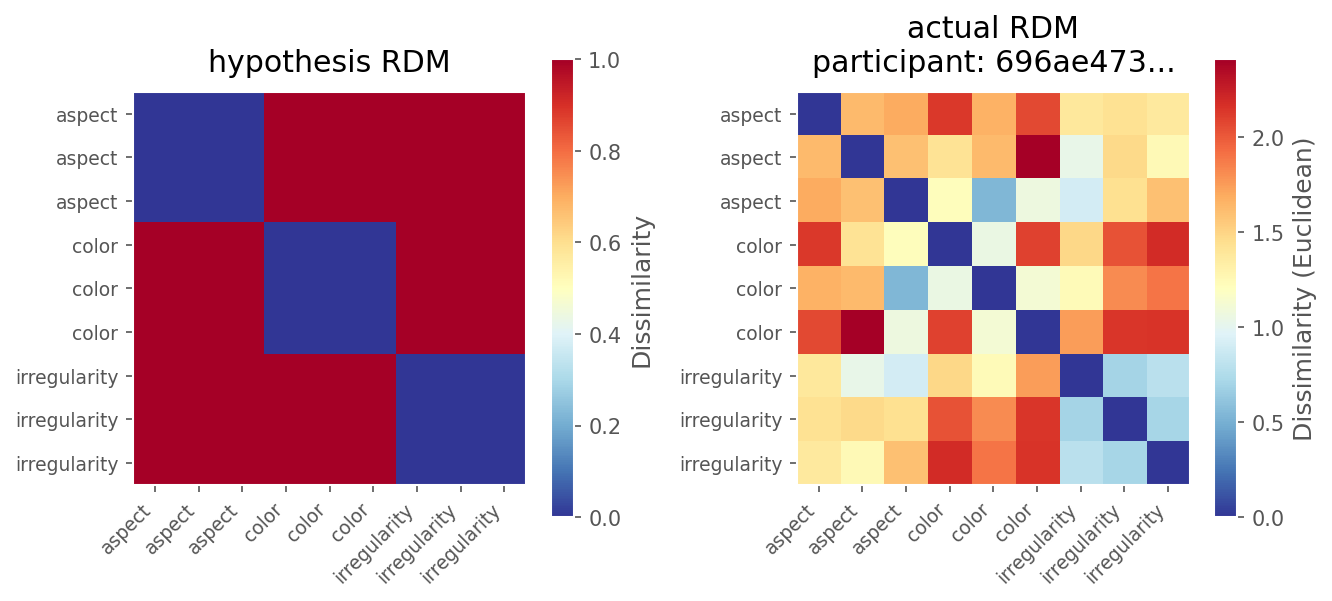

In [60]:
plt.figure(figsize=(9, 4), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(model_rdm, cmap='RdYlBu_r', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Dissimilarity')
attribute_labels = [cue_id[0] for cue_id in ordered_cues]
plt.yticks(range(len(ordered_cues)), attribute_labels, fontsize=9)
plt.xticks(range(len(ordered_cues)), attribute_labels, rotation=45, ha='right', fontsize=9)
plt.grid(False)
plt.title('hypothesis RDM', pad=10)
boundaries = []
for i in range(1, len(ordered_cues)):
    if ordered_cues[i][0] != ordered_cues[i-1][0]:
        boundaries.append(i - 0.5)

plt.subplot(1, 2, 2)
plt.imshow(behavioral_rdm, cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(label='Dissimilarity (Euclidean)')
plt.yticks(range(len(ordered_cues)), attribute_labels, fontsize=9)
plt.xticks(range(len(ordered_cues)), attribute_labels, rotation=45, ha='right', fontsize=9)
plt.grid(False)
plt.title(f'actual RDM\nparticipant: {test_participant_id[:8]}...', pad=10)

plt.tight_layout()
plt.show()

### RSA for all participants

In [62]:
all_rsa_correlations = []
all_behavioral_rdms = []
all_participant_conditions = []

for participant_id, participant_cues in tqdm(performances_by_participant_and_cue.items()):
    if len(participant_cues) == 9:
        rsa_corr, p_val, model_rdm, behavioral_rdm, ordered_cues = compute_rsa_correlation(
            participant_id, participant_cues
        )
        all_rsa_correlations.append(rsa_corr)
        all_behavioral_rdms.append(behavioral_rdm)
        
        condition = participant_conditions.get(participant_id, 'unknown')
        all_participant_conditions.append(condition)

print(f'\nComputed RSA for {len(all_rsa_correlations)} participants')
print(f'Musical condition: {all_participant_conditions.count("musical")} participants')
print(f'Referential condition: {all_participant_conditions.count("referential")} participants')

100%|██████████| 267/267 [00:00<00:00, 3545.29it/s]


Computed RSA for 256 participants
Musical condition: 128 participants
Referential condition: 128 participants


In [64]:
# Analyze RSA correlations across participants
musical_indices = [i for i, cond in enumerate(all_participant_conditions) if cond == 'musical']
referential_indices = [i for i, cond in enumerate(all_participant_conditions) if cond == 'referential']

# # Filter out NaN values (from participants with constant behavioral RDMs)
valid_correlations = [r for r in all_rsa_correlations if not np.isnan(r)]
musical_correlations = [all_rsa_correlations[i] for i in musical_indices if not np.isnan(all_rsa_correlations[i])]
referential_correlations = [all_rsa_correlations[i] for i in referential_indices if not np.isnan(all_rsa_correlations[i])]

# Average behavioral RDMs
mean_behavioral_rdm = np.mean(all_behavioral_rdms, axis=0)
mean_behavioral_rdm_musical = np.mean([all_behavioral_rdms[i] for i in musical_indices], axis=0)
mean_behavioral_rdm_referential = np.mean([all_behavioral_rdms[i] for i in referential_indices], axis=0)

print('RSA Correlation Statistics:')
print(f'\nAll participants:')
print(f'  Mean r = {np.mean(valid_correlations):.3f} ± {np.std(valid_correlations):.3f}')
print(f'  Median r = {np.median(valid_correlations):.3f}')

print(f'\nMusical condition:')
print(f'  Mean r = {np.mean(musical_correlations):.3f} ± {np.std(musical_correlations):.3f}')
print(f'  Median r = {np.median(musical_correlations):.3f}')

print(f'\nReferential condition:')
print(f'  Mean r = {np.mean(referential_correlations):.3f} ± {np.std(referential_correlations):.3f}')
print(f'  Median r = {np.median(referential_correlations):.3f}')

RSA Correlation Statistics:

All participants:
  Mean r = 0.195 ± 0.219
  Median r = 0.167

Musical condition:
  Mean r = 0.167 ± 0.218
  Median r = 0.133

Referential condition:
  Mean r = 0.225 ± 0.215
  Median r = 0.216


<Figure size 3000x800 with 0 Axes>

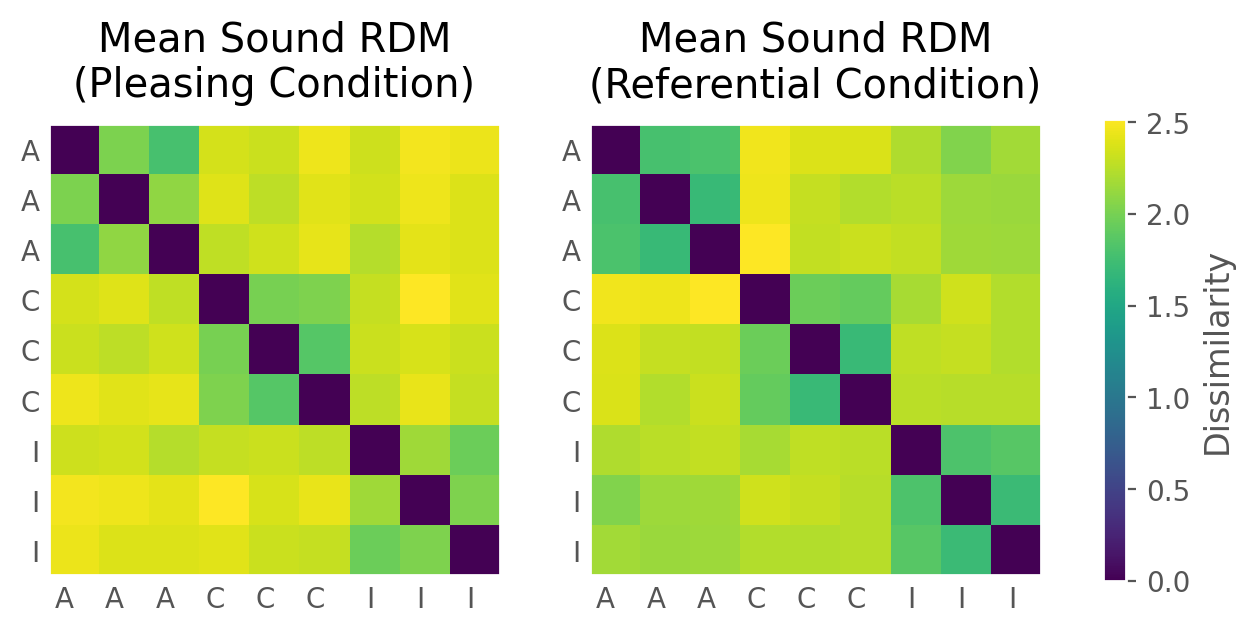

In [94]:
# Visualize the mean behavioral RDMs and RSA correlation distributions
plt.figure(figsize=(15, 4), dpi=200)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

attribute_labels = [label[0].upper() for label in attribute_labels]

im = axes[0].imshow(mean_behavioral_rdm_musical, cmap='viridis', interpolation='nearest')
axes[0].set_title(f'Mean Sound RDM\n(Pleasing Condition)', pad=10)
axes[0].set_yticks(range(9))
axes[0].set_xticks(range(9))
axes[0].set_yticklabels(attribute_labels, fontsize=10)
axes[0].set_xticklabels(attribute_labels, ha='right', fontsize=10)
axes[0].grid(False)
axes[0].tick_params(axis='both', which='both', length=0)

axes[1].imshow(mean_behavioral_rdm_referential, cmap='viridis', interpolation='nearest')
axes[1].set_title(f'Mean Sound RDM\n(Referential Condition)', pad=10)
axes[1].set_yticks(range(9))
axes[1].set_xticks(range(9))
axes[1].set_yticklabels(attribute_labels, fontsize=10)
axes[1].set_xticklabels(attribute_labels, ha='right', fontsize=10)
axes[1].grid(False)
axes[1].tick_params(axis='both', which='both', length=0)

fig.colorbar(im, ax=axes, label='Dissimilarity')
#     plt.axhline(boundary, color='black', linewidth=1.5, alpha=0.5)
#     plt.axvline(boundary, color='black', linewidth=1.5, alpha=0.5)

# plt.tight_layout()
plt.show()

### permutation tests

In [110]:
# for each participant, shuffle the pairing between model and behavioral RDMs
# and recompute correlation to create null distribution

def permutation_test_rsa(behavioral_rdms, model_rdm, n_permutations=1000):
    """
    Permutation test for RSA: shuffle the mapping between cues in behavioral RDMs
    and recompute correlations to create null distribution.
    """
    n_cues = model_rdm.shape[0]
    triu_indices = np.triu_indices(n_cues, k=1)
    model_vector = model_rdm[triu_indices]
    
    null_correlations = []
    
    for _ in tqdm(range(n_permutations), desc='Permutation test'):
        # For each permutation, shuffle behavioral RDM rows/cols together
        perm_corrs = []
        for behavioral_rdm in behavioral_rdms:
            # Permute the RDM by shuffling both rows and columns with same permutation
            perm_idx = np.random.permutation(n_cues)
            perm_rdm = behavioral_rdm[perm_idx, :][:, perm_idx]
            perm_vector = perm_rdm[triu_indices]
            
            # Compute correlation with model
            corr, _ = stats.spearmanr(model_vector, perm_vector)
            if not np.isnan(corr):
                perm_corrs.append(corr)
        
        # Average correlation across participants for this permutation
        null_correlations.append(np.mean(perm_corrs))
    
    return np.array(null_correlations)

# Get all behavioral RDMs (need to filter valid ones)
valid_behavioral_rdms = [all_behavioral_rdms[i] for i, r in enumerate(all_rsa_correlations) if not np.isnan(r)]
musical_behavioral_rdms = [all_behavioral_rdms[i] for i in musical_indices if not np.isnan(all_rsa_correlations[i])]
referential_behavioral_rdms = [all_behavioral_rdms[i] for i in referential_indices if not np.isnan(all_rsa_correlations[i])]

# Create model RDM (same for all participants with 9 cues)
sample_cues = list(performances_by_participant_and_cue[test_participant_id].keys())
cues_sorted = sorted(sample_cues, key=lambda x: (x[0], x[1]))
model_rdm_template = create_model_rdm(cues_sorted)

print('running permutation tests...')
null_dist_all = permutation_test_rsa(valid_behavioral_rdms, model_rdm_template, n_permutations=1000)
null_dist_musical = permutation_test_rsa(musical_behavioral_rdms, model_rdm_template, n_permutations=1000)
null_dist_referential = permutation_test_rsa(referential_behavioral_rdms, model_rdm_template, n_permutations=1000)

# Compute p-values
observed_mean_all = np.mean(valid_correlations)
observed_mean_musical = np.mean(musical_correlations)
observed_mean_referential = np.mean(referential_correlations)

p_perm_all = np.mean(null_dist_all >= observed_mean_all)
p_perm_musical = np.mean(null_dist_musical >= observed_mean_musical)
p_perm_referential = np.mean(null_dist_referential >= observed_mean_referential)

print('\nPermutation test results (RSA correlation vs null):')
print(f'All participants:        observed mean r={observed_mean_all:.3f}, p={p_perm_all:.4f}')
print(f'Musical condition:       observed mean r={observed_mean_musical:.3f}, p={p_perm_musical:.4f}')
print(f'Referential condition:   observed mean r={observed_mean_referential:.3f}, p={p_perm_referential:.4f}')


# Compare conditions: do musical vs referential differ in their RSA correlations?
t_stat_cond, p_value_cond = stats.ttest_ind(musical_correlations, referential_correlations)
print(f'\nCondition comparison (musical vs referential):')
print(f'  t={t_stat_cond:.3f}, p={p_value_cond:.6f}')

running permutation tests...


Permutation test: 100%|██████████| 1000/1000 [00:12<00:00, 82.43it/s]


Permutation test results (RSA correlation vs null):
All participants:        observed mean r=0.195, p=0.0000
Musical condition:       observed mean r=0.167, p=0.0000
Referential condition:   observed mean r=0.225, p=0.0000

Condition comparison (musical vs referential):
  t=-2.103, p=0.036478


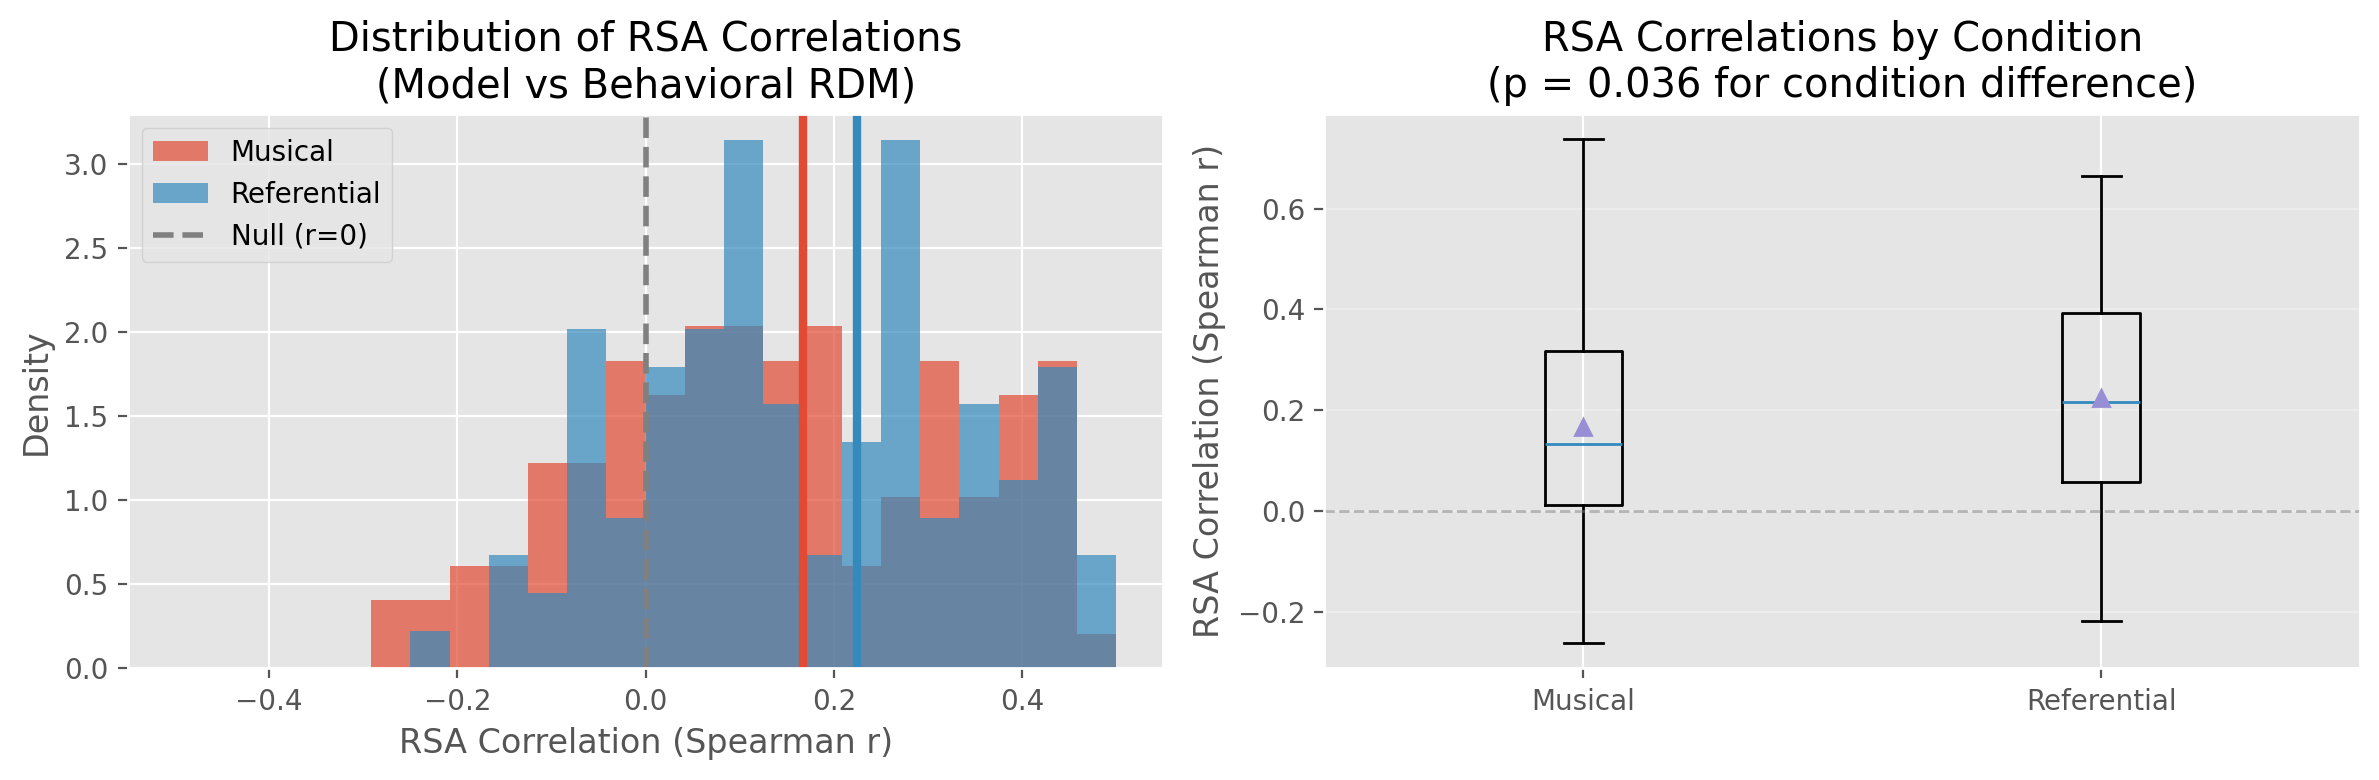

In [ ]:
# Visualize the distribution of RSA correlations
plt.figure(figsize=(12, 4), dpi=200)

# Histogram of correlations
plt.subplot(1, 2, 1)
bins = np.linspace(-0.5, 0.5, 25)
plt.hist(musical_correlations, bins=bins, alpha=0.7, label='Musical', density=True)
plt.hist(referential_correlations, bins=bins, alpha=0.7, label='Referential', density=True)
plt.axvline(0, color='gray', linestyle='--', linewidth=2, label='Null (r=0)')
plt.axvline(np.mean(musical_correlations), color='C0', linestyle='-', linewidth=3)
plt.axvline(np.mean(referential_correlations), color='C1', linestyle='-', linewidth=3)
plt.xlabel('RSA Correlation (Spearman r)')
plt.ylabel('Density')
plt.title('Distribution of RSA Correlations\n(Model vs Behavioral RDM)')
plt.legend()

# Box plot by condition
plt.subplot(1, 2, 2)
plt.boxplot([musical_correlations, referential_correlations], 
            labels=['Musical', 'Referential'],
            showmeans=True)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.ylabel('RSA Correlation (Spearman r)')
plt.title(f'RSA Correlations by Condition\n(p = {p_value_cond:.3f} for condition difference)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

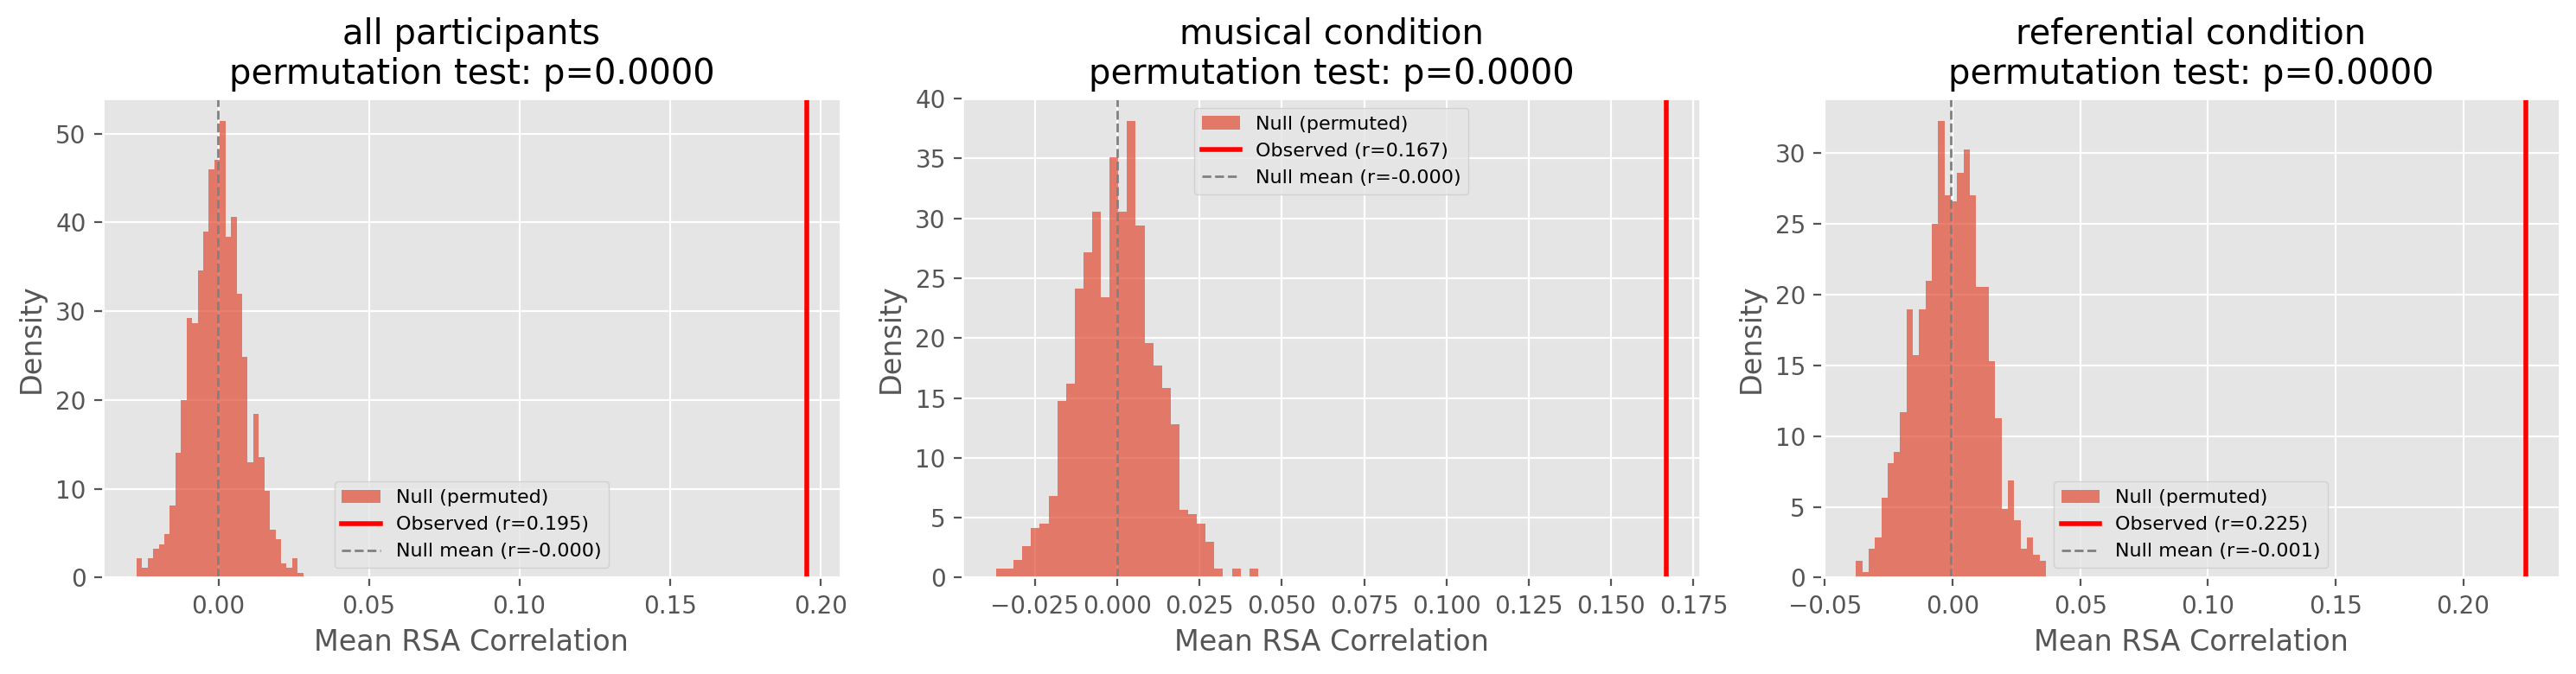

In [ ]:
# Visualize permutation test null distributions
plt.figure(figsize=(15, 4), dpi=200)

# All participants
plt.subplot(1, 3, 1)
plt.hist(null_dist_all, bins=30, alpha=0.7, density=True, label='Null (permuted)')
plt.axvline(observed_mean_all, color='red', linestyle='-', linewidth=2, label=f'Observed (r={observed_mean_all:.3f})')
plt.axvline(np.mean(null_dist_all), color='gray', linestyle='--', linewidth=1, label=f'Null mean (r={np.mean(null_dist_all):.3f})')
plt.xlabel('Mean RSA Correlation')
plt.ylabel('Density')
plt.title(f'all participants\npermutation test: p={p_perm_all:.4f}')
plt.legend(fontsize=8)

# Musical condition
plt.subplot(1, 3, 2)
plt.hist(null_dist_musical, bins=30, alpha=0.7, density=True, label='Null (permuted)')
plt.axvline(observed_mean_musical, color='red', linestyle='-', linewidth=2, label=f'Observed (r={observed_mean_musical:.3f})')
plt.axvline(np.mean(null_dist_musical), color='gray', linestyle='--', linewidth=1, label=f'Null mean (r={np.mean(null_dist_musical):.3f})')
plt.xlabel('Mean RSA Correlation')
plt.ylabel('Density')
plt.title(f'musical condition\npermutation test: p={p_perm_musical:.4f}')
plt.legend(fontsize=8)

# Referential condition
plt.subplot(1, 3, 3)
plt.hist(null_dist_referential, bins=30, alpha=0.7, density=True, label='Null (permuted)')
plt.axvline(observed_mean_referential, color='red', linestyle='-', linewidth=2, label=f'Observed (r={observed_mean_referential:.3f})')
plt.axvline(np.mean(null_dist_referential), color='gray', linestyle='--', linewidth=1, label=f'Null mean (r={np.mean(null_dist_referential):.3f})')
plt.xlabel('Mean RSA Correlation')
plt.ylabel('Density')
plt.title(f'referential condition\npermutation test: p={p_perm_referential:.4f}')
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

### Summary

- **model RDM**: Cues animating the same attribute have dissimilarity=0, otherwise dissimilarity=1
- **behavioral RDMs** show block structure
- **RSA correlations** (Spearman r between model and behavioral RDMs):
  - all participants (n=250): mean r = 0.195 ± 0.219, median r = 0.167
  - musical condition (n=126): mean r = 0.167 ± 0.218
  - referential condition (n=124): mean r = 0.225 ± 0.215
  - highly significant for both conditions (p < 0.0000000001)
  - feferential condition shows stronger RSA similarity with hypothesis (p = 0.036)

## diversity comparison

### each participant's avg pairwise distance

In [77]:
# Group mean pairwise distances by condition
musical_condition_distances = []
referential_condition_distances = []

for participant_id, data in mean_pairwise_distances_by_participant.items():
    condition = data['condition']
    distance = data['distance']
    
    if condition == 'musical':
        musical_condition_distances.append(distance)
    elif condition == 'referential':
        referential_condition_distances.append(distance)

# Calculate average pairwise distance for each condition
avg_musical_distance = np.mean(musical_condition_distances)
avg_referential_distance = np.mean(referential_condition_distances)

print(f'Musical condition:')
print(f'  Average pairwise distance: {avg_musical_distance:.3f}')
print(f'  N participants: {len(musical_condition_distances)}')

print(f'\nReferential condition:')
print(f'  Average pairwise distance: {avg_referential_distance:.3f}')
print(f'  N participants: {len(referential_condition_distances)}')

print(f'\nDifference: {avg_musical_distance - avg_referential_distance:.3f}')

Musical condition:
  Average pairwise distance: 2.289
  N participants: 131

Referential condition:
  Average pairwise distance: 2.257
  N participants: 133

Difference: 0.032


100%|██████████| 1000/1000 [00:00<00:00, 42313.28it/s]


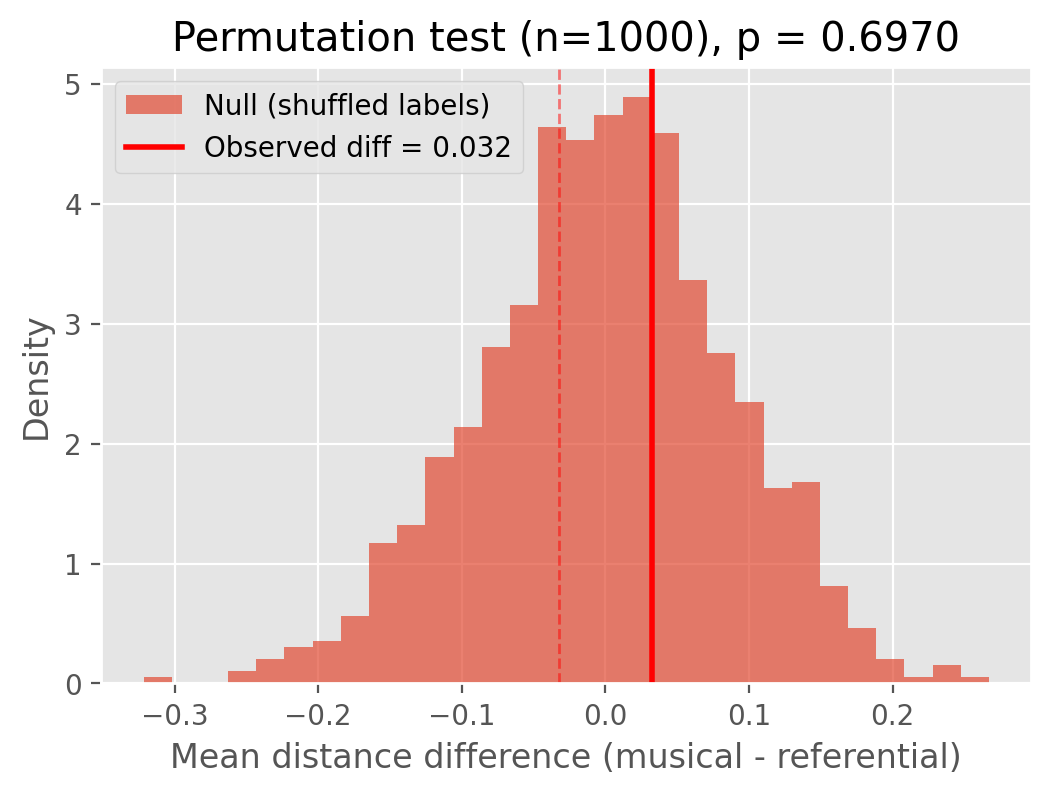

Observed difference: 0.032328
Permutation test p-value (two-sided): 0.6970


In [78]:
# Permutation test on mean pairwise distances by condition
participant_ids = list(mean_pairwise_distances_by_participant.keys())
distances = np.array([mean_pairwise_distances_by_participant[pid]['distance'] for pid in participant_ids])
labels = np.array([mean_pairwise_distances_by_participant[pid]['condition'] for pid in participant_ids])

observed_diff = distances[labels == 'musical'].mean() - distances[labels == 'referential'].mean()

n_permutations = 1000
rng = np.random.default_rng(0)
null_diffs = []

for _ in tqdm(range(n_permutations)):
    shuffled_labels = rng.permutation(labels)
    diff = distances[shuffled_labels == 'musical'].mean() - distances[shuffled_labels == 'referential'].mean()
    null_diffs.append(diff)

null_diffs = np.array(null_diffs)
p_value = np.mean(np.abs(null_diffs) >= abs(observed_diff))

plt.figure(figsize=(6, 4), dpi=200)
plt.hist(null_diffs, bins=30, density=True, alpha=0.7, label='Null (shuffled labels)')
plt.axvline(observed_diff, color='red', linewidth=2, label=f'Observed diff = {observed_diff:.3f}')
plt.axvline(-observed_diff, color='red', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel('Mean distance difference (musical - referential)')
plt.ylabel('Density')
plt.title(f'Permutation test (n=1000), p = {p_value:.4f}')
plt.legend()
plt.show()

print(f'Observed difference: {observed_diff:.6f}')
print(f'Permutation test p-value (two-sided): {p_value:.4f}')

### big buckets for each condition

In [79]:
# Compute average pairwise distance across all performances within each condition
def average_pairwise_distance(features_list):
    if len(features_list) < 2:
        return np.nan
    feature_matrix = np.array([
        [f.get('com_x', 0), f.get('com_y', 0), f.get('std_x', 0), f.get('std_y', 0), f.get('curvature', 0)]
        for f in features_list
    ])
    n = feature_matrix.shape[0]
    dists = []
    for i in range(n):
        diff = feature_matrix[i+1:] - feature_matrix[i]
        dists.extend(np.linalg.norm(diff, axis=1))
    return float(np.mean(dists))

musical_features = [
    p['trace_features_scaled'] for p in performances_data
    if p.get('condition') == 'musical' and p.get('trace_features_scaled')
]
referential_features = [
    p['trace_features_scaled'] for p in performances_data
    if p.get('condition') == 'referential' and p.get('trace_features_scaled')
]

avg_musical_pairwise = average_pairwise_distance(musical_features)
avg_referential_pairwise = average_pairwise_distance(referential_features)

print(f'Average pairwise distance (musical, all traces): {avg_musical_pairwise:.3f}')
print(f'Average pairwise distance (referential, all traces): {avg_referential_pairwise:.3f}')

Average pairwise distance (musical, all traces): 2.928
Average pairwise distance (referential, all traces): 2.935


Permutation test: 100%|██████████| 10000/10000 [00:01<00:00, 6152.64it/s]


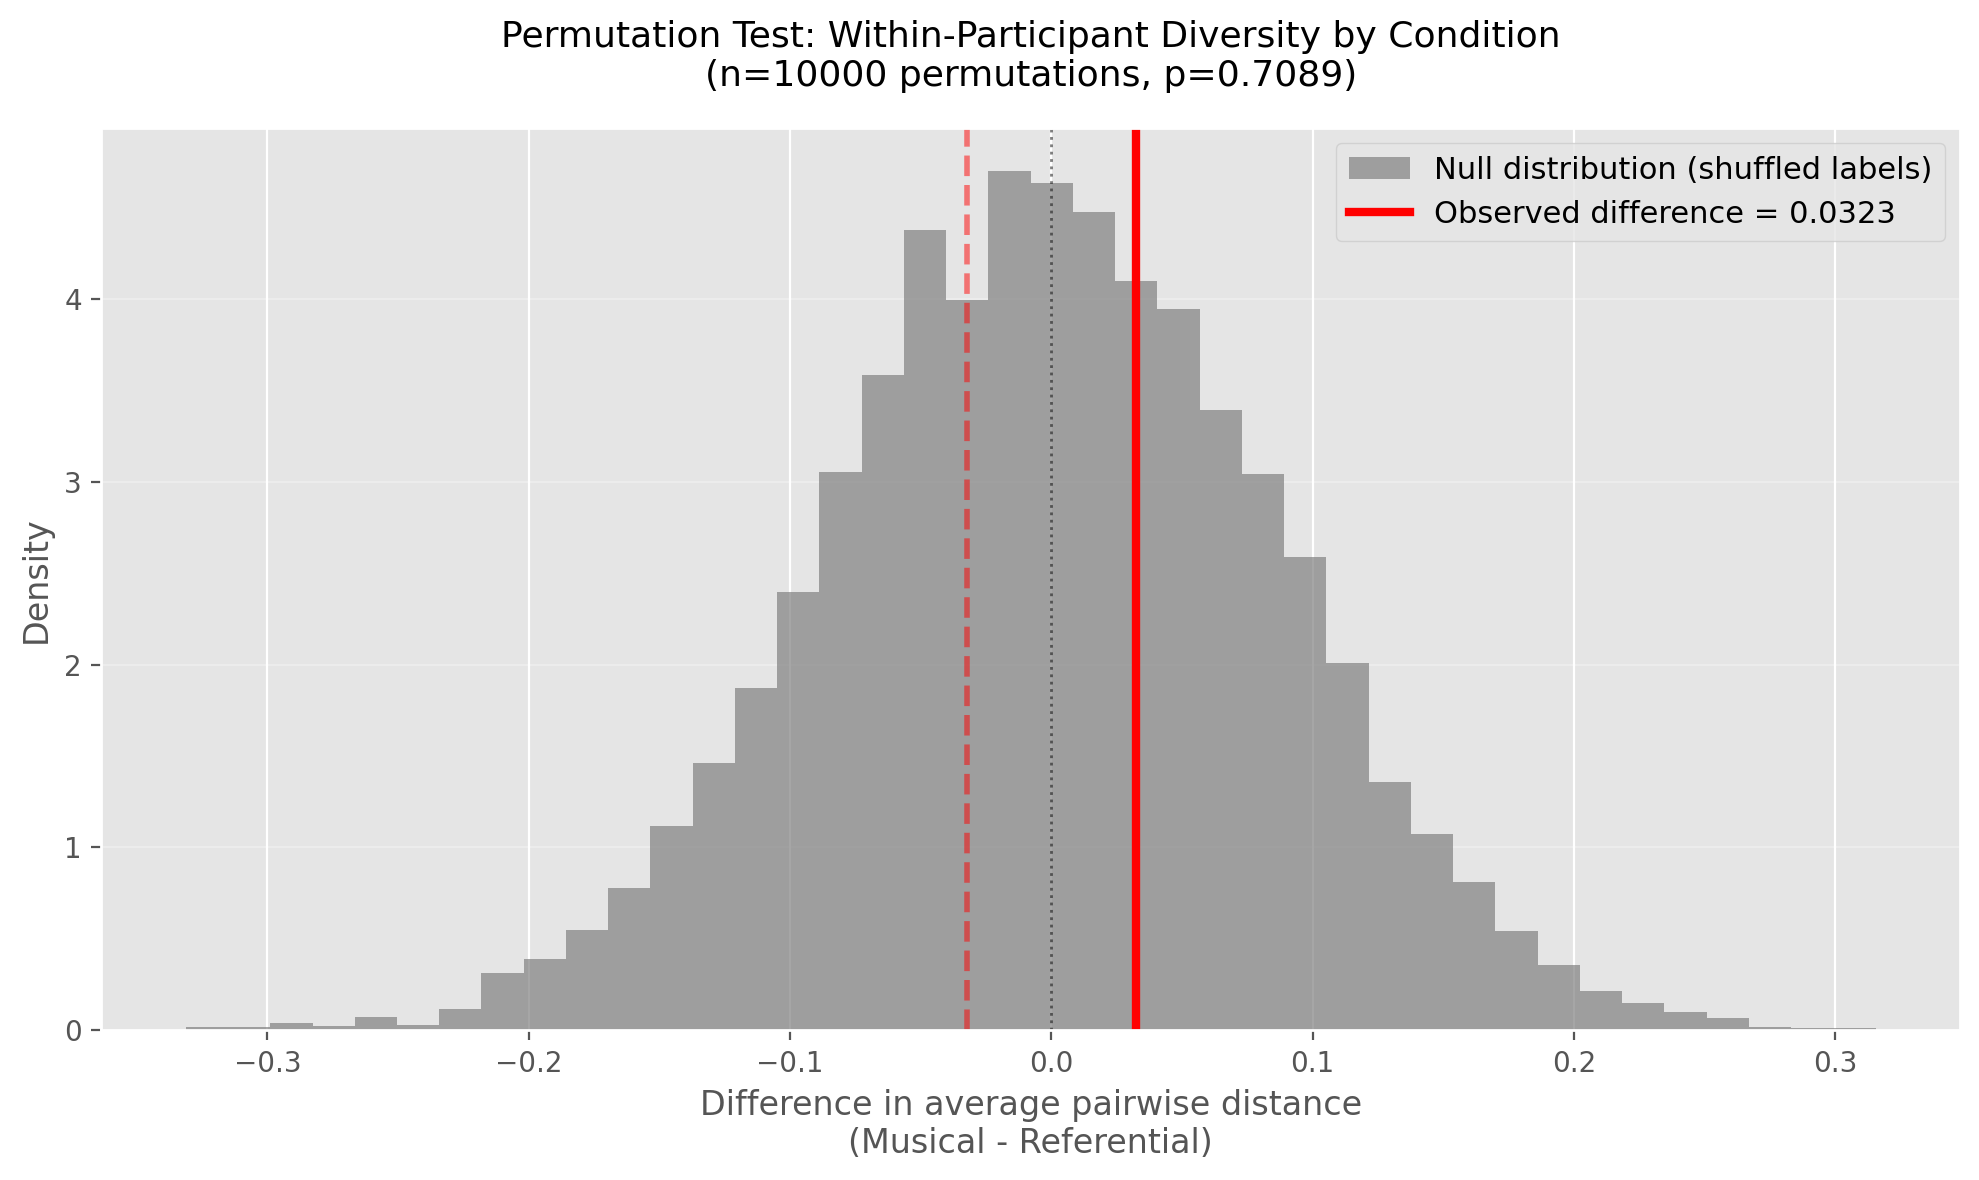


PERMUTATION TEST RESULTS

Observed averages:
  Musical condition:      2.2894
  Referential condition:  2.2571
  Difference:             0.0323

Null distribution (shuffled labels):
  Mean difference:        -0.0005
  Std difference:         0.0862

Permutation test p-value (two-tailed): 0.7089


In [81]:
# Permutation test: randomly assign participants to conditions and compare average pairwise distances
n_permutations = 10000
rng = np.random.default_rng(0)

# Get all participant IDs and their actual distances
participant_ids = list(mean_pairwise_distances_by_participant.keys())
distances = {pid: mean_pairwise_distances_by_participant[pid]['distance'] for pid in participant_ids}

# Observed difference in average pairwise distance between conditions
musical_avg = np.mean([distances[pid] for pid in participant_ids 
                       if mean_pairwise_distances_by_participant[pid]['condition'] == 'musical'])
referential_avg = np.mean([distances[pid] for pid in participant_ids 
                           if mean_pairwise_distances_by_participant[pid]['condition'] == 'referential'])
observed_diff = musical_avg - referential_avg

# Run permutation test
null_musical_avgs = []
null_referential_avgs = []

for _ in tqdm(range(n_permutations), desc='Permutation test'):
    # Randomly shuffle condition labels
    shuffled_conditions = rng.permutation(['musical'] * len(musical_condition_distances) + 
                                         ['referential'] * len(referential_condition_distances))
    
    # Split distances according to shuffled labels
    all_distances = musical_condition_distances + referential_condition_distances
    shuffled_musical = [all_distances[i] for i in range(len(all_distances)) if shuffled_conditions[i] == 'musical']
    shuffled_referential = [all_distances[i] for i in range(len(all_distances)) if shuffled_conditions[i] == 'referential']
    
    null_musical_avgs.append(np.mean(shuffled_musical))
    null_referential_avgs.append(np.mean(shuffled_referential))

null_diffs = np.array(null_musical_avgs) - np.array(null_referential_avgs)

# Calculate p-value (two-tailed)
p_value = np.mean(np.abs(null_diffs) >= np.abs(observed_diff))

# Visualization
plt.figure(figsize=(10, 6), dpi=200)

plt.hist(null_diffs, bins=40, density=True, alpha=0.7, color='gray', 
         label='Null distribution (shuffled labels)')
plt.axvline(observed_diff, color='red', linewidth=3, linestyle='-', 
            label=f'Observed difference = {observed_diff:.4f}')
plt.axvline(-observed_diff, color='red', linewidth=2, linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linewidth=1, linestyle=':', alpha=0.5)

plt.xlabel('Difference in average pairwise distance\n(Musical - Referential)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Permutation Test: Within-Participant Diversity by Condition\n(n={n_permutations} permutations, p={p_value:.4f})', 
          fontsize=13, pad=15)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print(f'\n{"="*60}')
print(f'PERMUTATION TEST RESULTS')
print(f'{"="*60}')
print(f'\nObserved averages:')
print(f'  Musical condition:      {musical_avg:.4f}')
print(f'  Referential condition:  {referential_avg:.4f}')
print(f'  Difference:             {observed_diff:.4f}')
print(f'\nNull distribution (shuffled labels):')
print(f'  Mean difference:        {np.mean(null_diffs):.4f}')
print(f'  Std difference:         {np.std(null_diffs):.4f}')
print(f'\nPermutation test p-value (two-tailed): {p_value:.4f}')
print(f'{"="*60}')